In [51]:
import pandas as pd
import plotnine as pn
import numpy as np

from tqdm import tqdm

In [52]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

density  edginess  references  citations_per_year  is_center  \
0       1545.550332  0.814415          42            2.250000      False   
1       1846.261870  0.452021          88            4.625000      False   
2       1703.520959  0.490212          30            0.882353      False   
3       1901.386693  0.715160          95            8.166667      False   
4        535.472125  0.885892          94            2.090909      False   
...             ...       ...         ...                 ...        ...   
529397    48.730838  0.658585          41            3.500000      False   
529398    25.107589  0.721374          38            3.200000      False   
529399    41.647954  0.646499          11            1.529412      False   
529400    35.738649  0.708053          15            2.384615      False   
529401    31.749805  0.670620           7            0.000000      False   

                                      identifier  year librarian vectorizer  \
0       2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f  2004        S2       GPT2   
1       d7b6cd39dd111afa55a3aa418b7b5459db12988d  2012        S2       GPT2   
2       2d62ec65f95435c72ef750b3cff331382c5dca92  2003        S2       GPT2   
3       8cebc6e3dcfb543bad48d89112e281a6e11c33c2  2014        S2       GPT2   
4       59730a4bae4dc53f59341b63fd1e63451c589e9f  2009        S2       GPT2   
...                                          ...   ...       ...        ...   
529397  806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24  2018        S2    SciBERT   
529398  f40707d1165c22e185c25e6837977177ee380f2c  2015        S2    SciBERT   
529399  10636ee16779a7521001651164acb5c192d4ad7b  2003        S2    SciBERT   
529400  a229f829e0a5362d00e63781f687f40ede991635  2007        S2    SciBERT   
529401  8f7f47c0acd81752039abad380df57cf39591506  2012        S2    SciBERT   

                                center fields_of_study_0  
0       hafenLowredshiftLymanLimit2017           Physics  
1       hafenLowredshiftLymanLimit2017           Physics  
2       hafenLowredshiftLymanLimit2017           Physics  
3       hafenLowredshiftLymanLimit2017           Physics  
4       hafenLowredshiftLymanLimit2017           Physics  
...                                ...               ...  
529397                       Andre2018       Mathematics  
529398                       Andre2018       Mathematics  
529399                       Andre2018       Mathematics  
529400                       Andre2018       Mathematics  
529401                       Andre2018       Mathematics  

[529402 rows x 11 columns]

In [53]:
# df_all = df_all[df_all["year"] == 2018]
vectorizer = "BOW"
df_all = df_all[df_all["vectorizer"] == vectorizer]
# df_all = df_all[df_all["vectorizer"] == "Word2Vec"]

In [54]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [55]:
# df = df_all[df_all["citations_per_year"] > 0]
# df = df_all[df_all["density"] < 100] # hacky
df = df_all
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/81577959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/81577959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 20) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    data_bins = df[["log_cpy", "density_bin", "citations_per_year", "references", "year"]]

    log_ents = [
        entropy_estimator(
            observations=data_bins[data_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # forget about entropy, we have a continuous variable so look at variance instead
    log_variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    
    # and median
    log_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    means = [
            np.nanmean(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    ref_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["references"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    
    ref_variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["references"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    year_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]


    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(
            bins, 
            df.density_bin.value_counts(sort=False, normalize=True), 
            df.density_bin.value_counts(sort=False, normalize=False),
            log_ents, 
            log_variances,
            log_medians,
            variances,
            medians,
            means,
            ref_medians,
            ref_variances,
            year_medians,
            ),
        columns=[
            "density_bin", 
            "freq", 
            "count", 
            "log_cpy entropy", 
            "log_cpy variance",
            "log_cpy median",
            "cpy_var",
            "cpy_med",
            "cpy_mean",
            "ref_med",
            "ref_var",
            "year_med",
        ],
    )
    df_ent["field"] = field

    return df_ent


In [57]:
# Zach's algo

def get_df_var(df_in: pd.DataFrame, field: str, num_bins = 100, n_bin = 100) -> pd.DataFrame:
    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # TODO: can we annotate the percentiles for these bins?
    

    # n_bin = 200 # play with this
    # sample_size = 200

    d_bins = df.density_bin.unique()
    data = []

    for d_bin in d_bins:
        df_bin: pd.DataFrame = df[df["density_bin"] == d_bin]
        n_in_density_bin = len(df_bin)
        n_steps = int(n_in_density_bin / n_bin)
        data_sorted_by_cpy = df_bin.sample(frac=1)
        

        for step in range(0, n_steps, n_bin):
            # data_sorted_by_cpy = df_bin.sort_values("citations_per_year")
            # if sample_size > len(df_bin):
                # raise Exception
            # data_sorted_by_cpy = df_bin.sample(frac=1)
            # print("ALL OBSERVATIONS: ", data_sorted_by_cpy)
            if n_bin > len(df_bin):
                raise Exception
            data_to_bin = df_bin.sample(n_bin)
            # data_to_bin = data_sorted_by_cpy[step: step + n_bin]

            var_cpy_in_density_bin = np.nanvar(data_to_bin["citations_per_year"])
            var_log_cpy_in_density_bin = np.nanvar(data_to_bin["log_cpy"])

            median_density_in_density_bin = np.nanmedian(data_to_bin["density"])
            median_cpy_in_density_bin = np.nanmedian(data_to_bin["citations_per_year"])
            mean_cpy_in_density_bin = np.nanmean(data_to_bin["citations_per_year"])
            median_log_cpy_in_density_bin = np.nanmedian(data_to_bin["log_cpy"])

            data.append(
                (
                    median_density_in_density_bin, 
                    median_cpy_in_density_bin,
                    mean_cpy_in_density_bin,
                    median_log_cpy_in_density_bin,
                    var_cpy_in_density_bin,
                    var_log_cpy_in_density_bin,
                    field,
                )
            )
    
    return pd.DataFrame(
        data,
        columns=[
            "density_med_bin", 
            "cpy_med_bin", 
            "cpy_mean_bin",
            "log_cpy_med_bin",
            "cpy_var",
            "log_cpy_var", 
            "field",
        ],
    )


get_df_var(df, "Physics", n_bin=10)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_med_bin  cpy_med_bin  cpy_mean_bin  log_cpy_med_bin      cpy_var  \
0          53.172762     5.833333     11.814167         0.757052   214.691056   
1          53.009294     8.485714     16.290198         0.917347   236.505257   
2          52.987835     4.477778      5.033095         0.658541     9.965065   
3          56.145425     6.666667      9.964697         0.823365    51.518790   
4          56.339738     5.409091     14.655115         0.713477   775.379383   
..               ...          ...           ...              ...          ...   
135        31.058496    12.250000     13.740797         1.083659   109.141737   
136        62.686797    12.500000     11.877143         1.230449    69.323237   
137        35.741265     6.625000     10.302635         0.819245   121.919341   
138        34.733766     4.535714     25.623139         0.646602  2366.622172   
139        30.407385     6.450000      7.360470         0.973128    34.299782   

     log_cpy_var    field  
0       0.206897  Physics  
1       0.244120  Physics  
2       0.050943  Physics  
3       0.111375  Physics  
4       0.358567  Physics  
..           ...      ...  
135     0.211454  Physics  
136     0.120171  Physics  
137     0.561785  Physics  
138     0.452542  Physics  
139     0.289432  Physics  

[140 rows x 7 columns]

#### New scatterplot with trendlines

Why are the trends so robustly U-shaped?

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

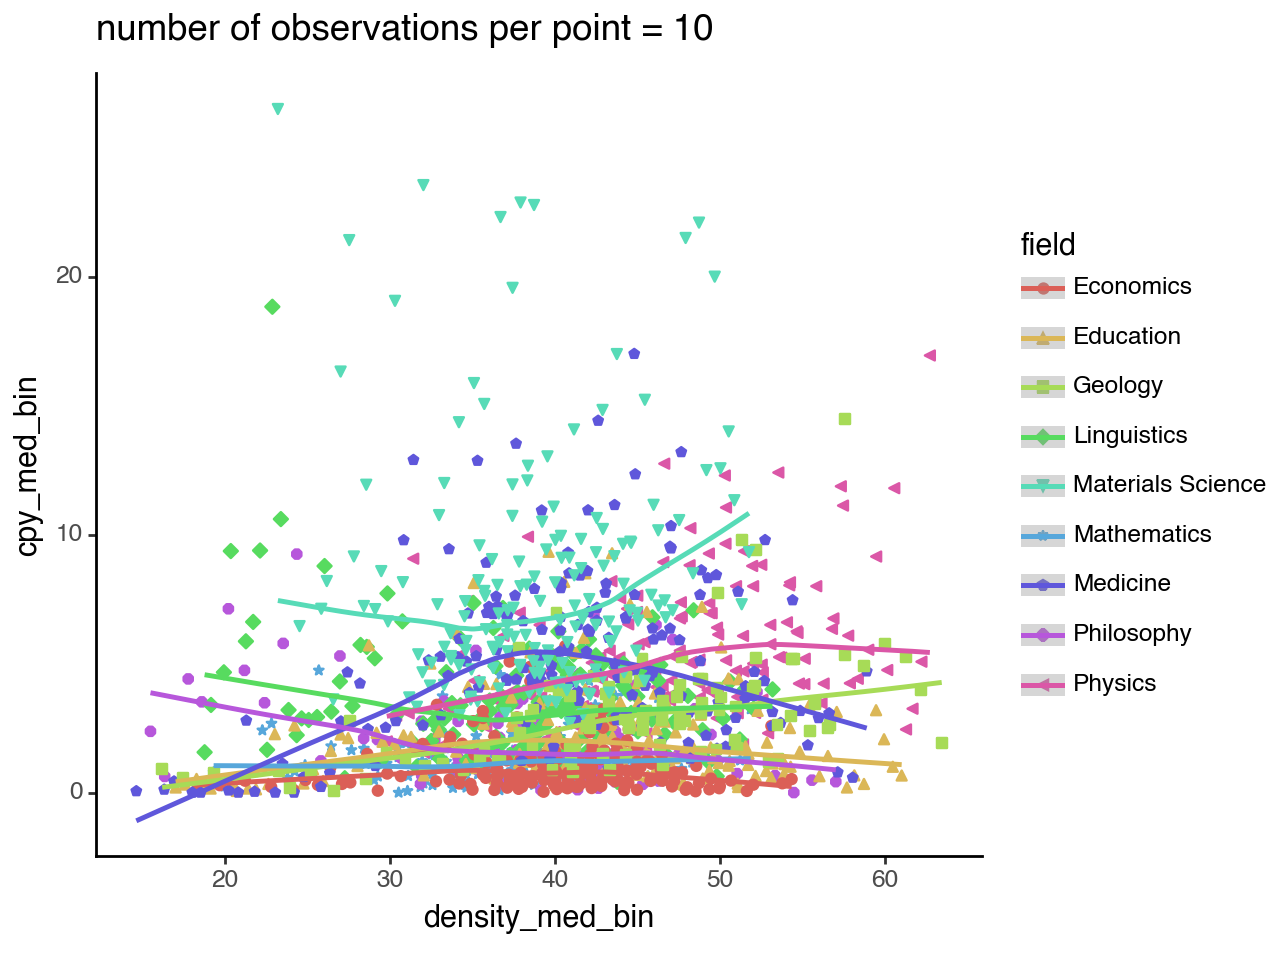

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

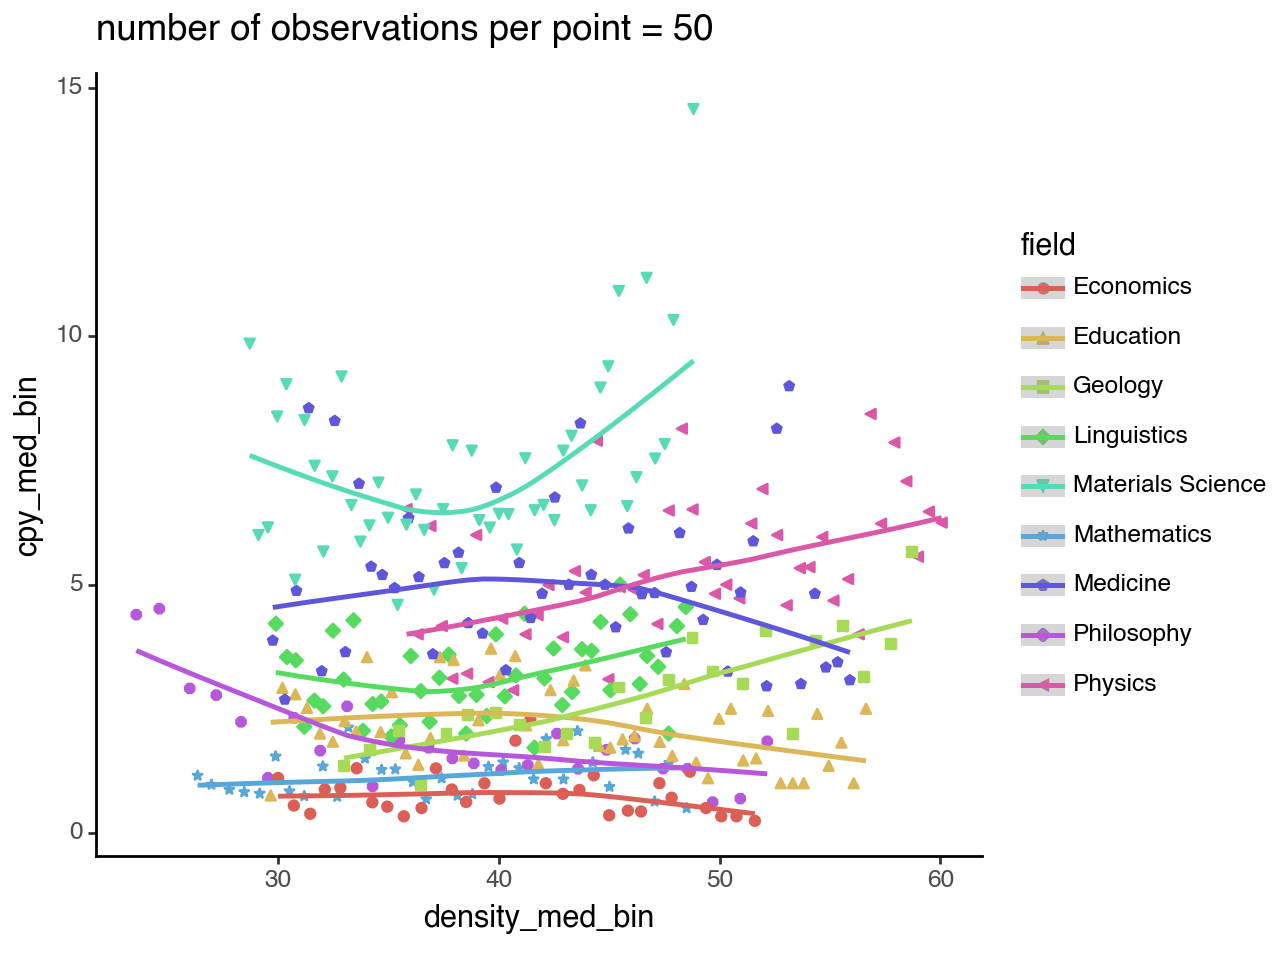

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

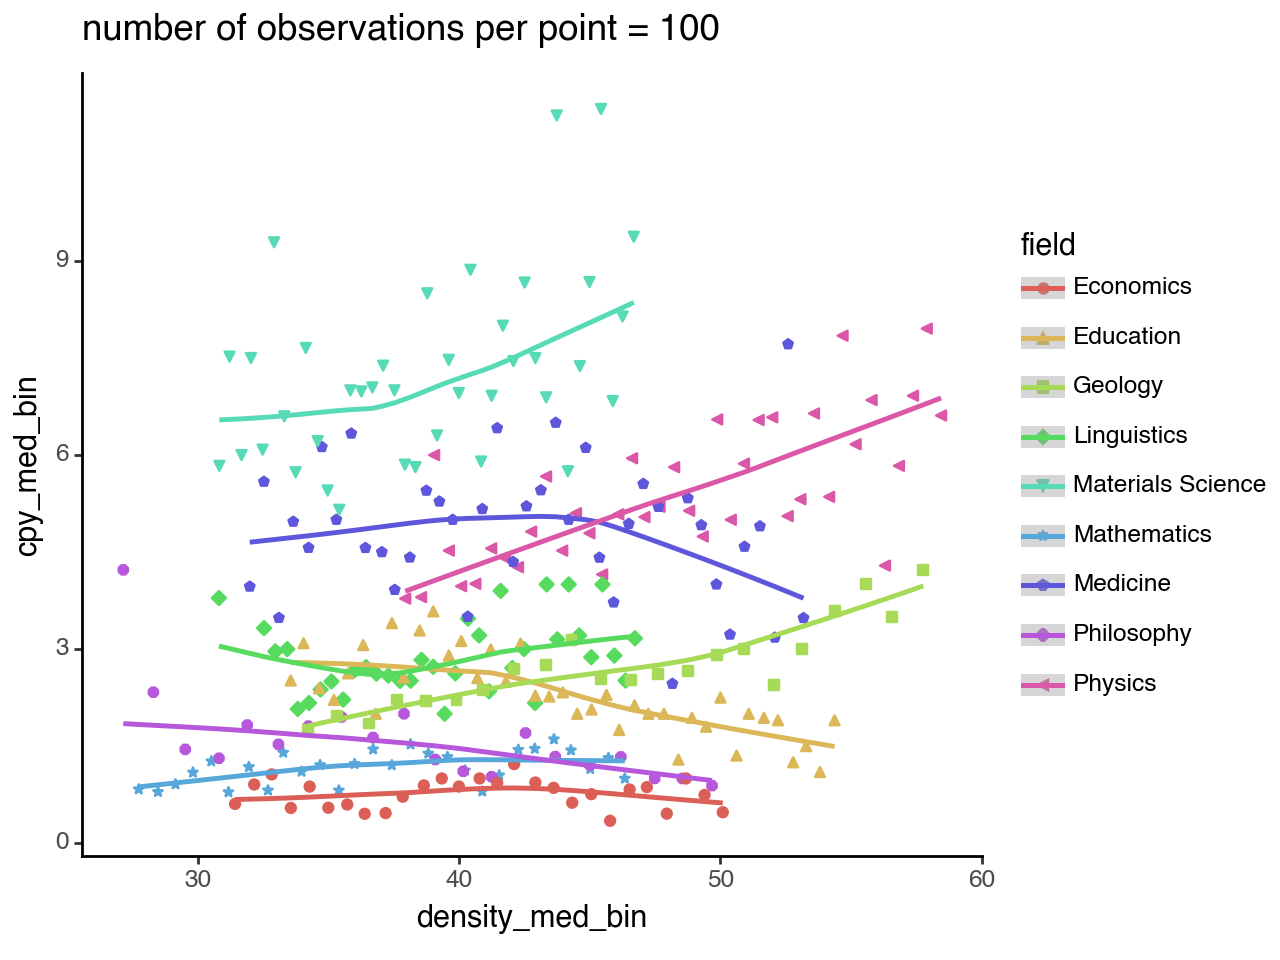

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

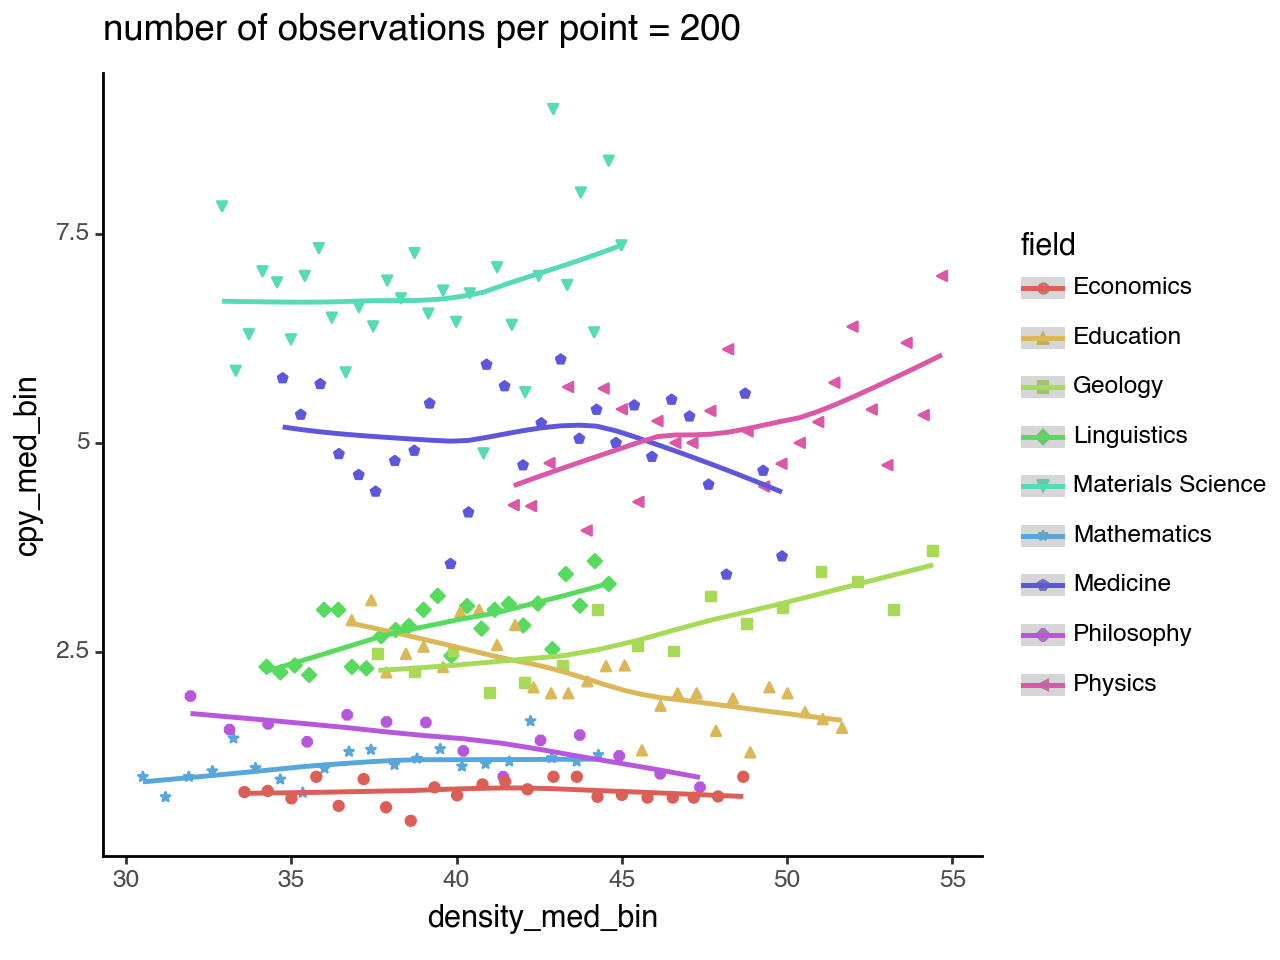

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

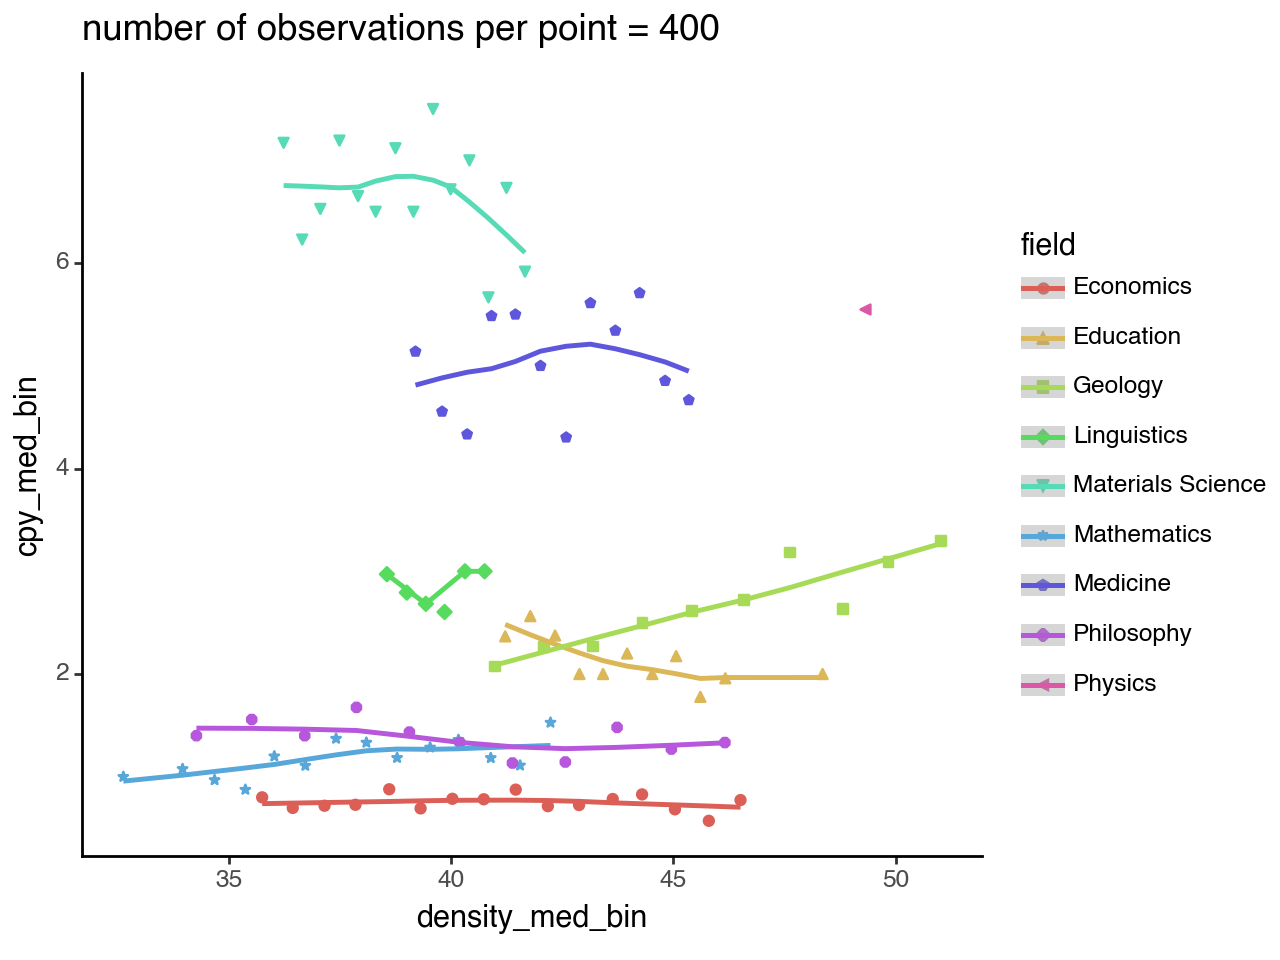

In [58]:
for n_bin in [10, 50, 100, 200, 400]:

    print(
        pn.ggplot(
            pd.concat(
            [get_df_var(df, field, n_bin=n_bin)
            for field in df["fields_of_study_0"].unique()],
            ),
            pn.aes(
                x="density_med_bin",
                # y="log_cpy_med_bin",
                # y="log_cpy_var",
                y="cpy_med_bin",
                # y="cpy_var",
                # color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                shape="field",
                color="field",
            ),
            # color="black",
            # alpha=0.1,
        )
        + pn.geom_smooth(
            pn.aes(
                color="field",
            )
        )
        # + pn.ylab("Variance in citations per year")
        # + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
        # + pn.ylim(0,2)
        + pn.ggtitle(f"number of observations per point = {n_bin}")
    )

In [59]:
pd.concat(
    [get_df_var(df, field, n_bin=100)
    for field in df["fields_of_study_0"].unique()],
).to_csv("dmb_vs_log_cpy_var.csv", index=False)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [60]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        13.416  0.000450      5              NaN          0.542791   
1        16.114  0.001800     20              NaN          0.144183   
2        18.811  0.001890     21              NaN          0.207678   
3        21.508  0.001530     17              NaN          0.284733   
4        24.206  0.002700     30              NaN          0.386553   
5        26.903  0.002969     33              NaN          0.497729   
6        29.600  0.007649     85              NaN          0.372062   
7        32.297  0.013948    155              NaN          0.452865   
8        34.995  0.031225    347              NaN          0.395920   
9        37.692  0.057680    641              NaN          0.367117   
10       40.389  0.093314   1037              NaN          0.306475   
11       43.087  0.136597   1518              NaN          0.264054   
12       45.784  0.157563   1751              NaN          0.247440   
13       48.481  0.170521   1895              NaN          0.238984   
14       51.179  0.141996   1578              NaN          0.232078   
15       53.876  0.095294   1059              NaN          0.219674   
16       56.573  0.054711    608              NaN          0.229719   
17       59.271  0.021866    243              NaN          0.212282   
18       61.968  0.004589     51              NaN          0.233174   
19       64.665  0.001710     19              NaN          0.261128   

    log_cpy median      cpy_var   cpy_med   cpy_mean  ref_med       ref_var  \
0        -0.108355     2.844694  0.000000   0.878571     30.0   2693.760000   
1         0.740363    25.554117  4.402256   4.875897     51.0   2739.927500   
2         0.568072    49.653469  3.500000   6.297490     79.0   3009.741497   
3         0.397940    26.090277  1.687500   4.680071     44.0   7041.467128   
4         0.861125   657.461221  4.968750  14.245751     35.5   2814.872222   
5         0.816012   611.850195  3.466667  14.677084     53.0   3187.015611   
6         0.798756  1571.028369  4.058824  15.792755     49.0  19370.772872   
7         0.631016   328.334208  3.642857   9.835203     42.0   8715.262185   
8         0.746894  3694.807381  4.750000  13.960217     40.0   3351.603003   
9         0.677571   331.892599  4.400000   9.239674     46.0   4642.391870   
10        0.670197  5291.651688  4.315789  11.930705     48.0   3032.792543   
11        0.708043   147.872931  5.000000   8.729055     54.0   1805.035662   
12        0.740363   892.039953  5.266667  10.227194     60.0   1826.555272   
13        0.756125   177.519078  5.500000   9.365258     64.0   1698.897656   
14        0.770852   147.622432  5.666667   9.666792     70.0   1781.481910   
15        0.780402   224.392310  6.000000  10.229361     77.0   1692.320974   
16        0.814761   295.608521  6.500000  11.807838     84.0   1976.138926   
17        0.820259   120.488750  6.111111   9.916074     88.0   2157.063286   
18        0.960233   219.470918  8.000000  12.828051     90.0   2610.306805   
19        0.671211    54.041834  4.000000   6.758987    100.0   1245.578947   

    year_med    field  
0     2013.0  Physics  
1     2013.0  Physics  
2     2013.0  Physics  
3     2013.0  Physics  
4     2013.5  Physics  
5     2013.0  Physics  
6     2009.0  Physics  
7     2009.0  Physics  
8     2009.0  Physics  
9     2009.0  Physics  
10    2010.0  Physics  
11    2010.5  Physics  
12    2012.0  Physics  
13    2012.0  Physics  
14    2013.0  Physics  
15    2014.0  Physics  
16    2014.0  Physics  
17    2015.0  Physics  
18    2015.0  Physics  
19    2016.0  Physics

In [61]:
df_ent_all = pd.concat(
    [get_df_ent(df, field, num_bins=100)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:44: RuntimeW

density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        13.416  0.000090      1              NaN               NaN   
1        13.956  0.000000      0              NaN               NaN   
2        14.495  0.000090      1              NaN               NaN   
3        15.035  0.000090      1              NaN               0.0   
4        15.574  0.000180      2              NaN               0.0   
..          ...       ...    ...              ...               ...   
95       79.877  0.000000      0              NaN               NaN   
96       80.567  0.000000      0              NaN               NaN   
97       81.258  0.000000      0              NaN               NaN   
98       81.948  0.000000      0              NaN               NaN   
99       82.638  0.000087      1              NaN               0.0   

    log_cpy median   cpy_var   cpy_med  cpy_mean  ref_med  ref_var  year_med  \
0              NaN  0.000000  0.000000  0.000000    109.0     0.00    2015.0   
1              NaN       NaN       NaN       NaN      NaN      NaN       NaN   
2              NaN  0.000000  0.000000  0.000000    129.0     0.00    2008.0   
3        -0.845098  0.000000  0.142857  0.142857     13.0     0.00    2013.0   
4         0.628389  4.515625  2.125000  2.125000     16.5   182.25    2013.0   
..             ...       ...       ...       ...      ...      ...       ...   
95             NaN       NaN       NaN       NaN      NaN      NaN       NaN   
96             NaN       NaN       NaN       NaN      NaN      NaN       NaN   
97             NaN       NaN       NaN       NaN      NaN      NaN       NaN   
98             NaN       NaN       NaN       NaN      NaN      NaN       NaN   
99       -0.301030  0.000000  0.500000  0.500000    141.0     0.00    2018.0   

          field  
0       Physics  
1       Physics  
2       Physics  
3       Physics  
4       Physics  
..          ...  
95  Mathematics  
96  Mathematics  
97  Mathematics  
98  Mathematics  
99  Mathematics  

[900 rows x 13 columns]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


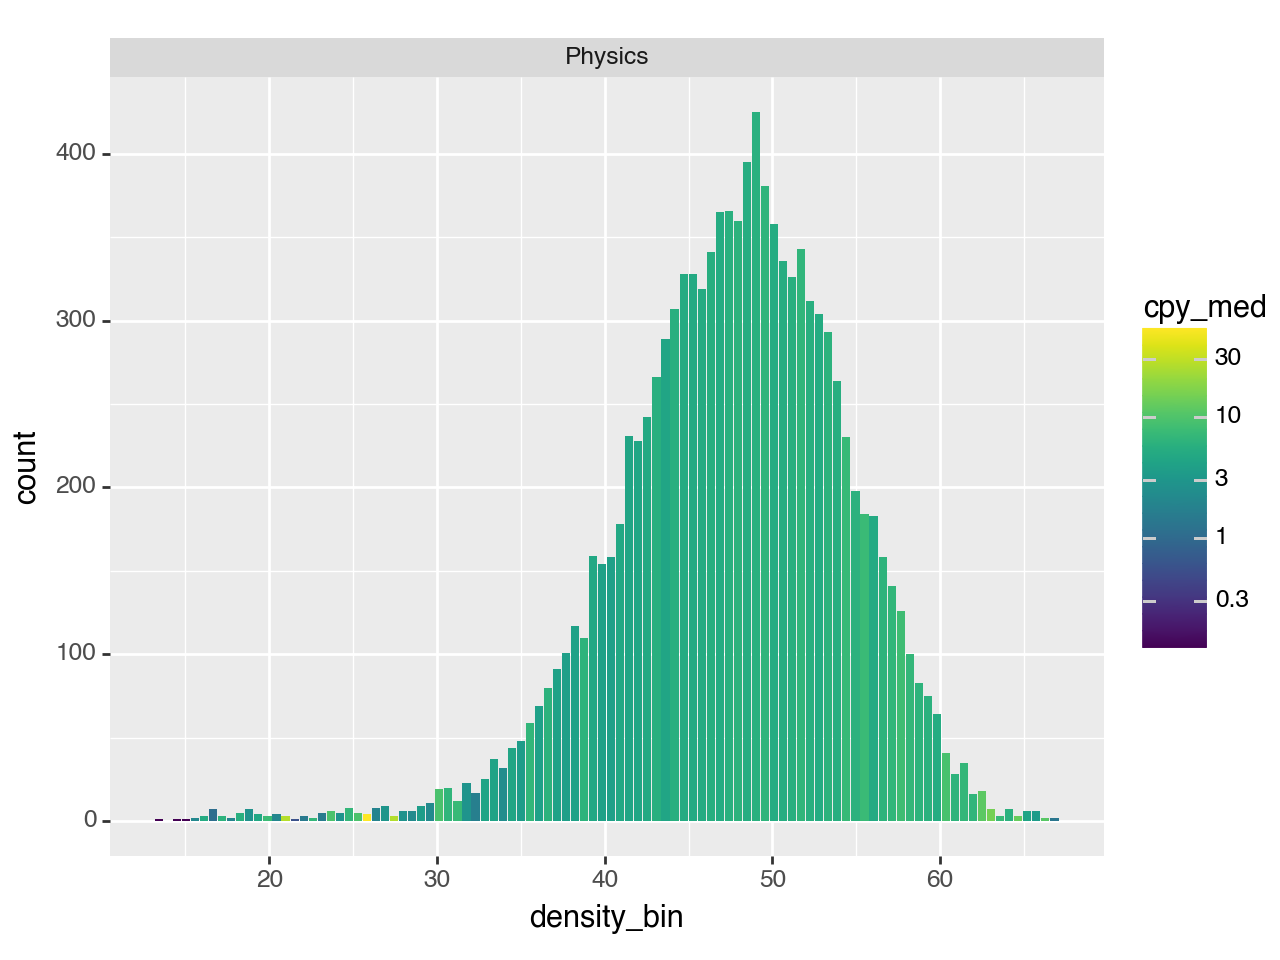

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


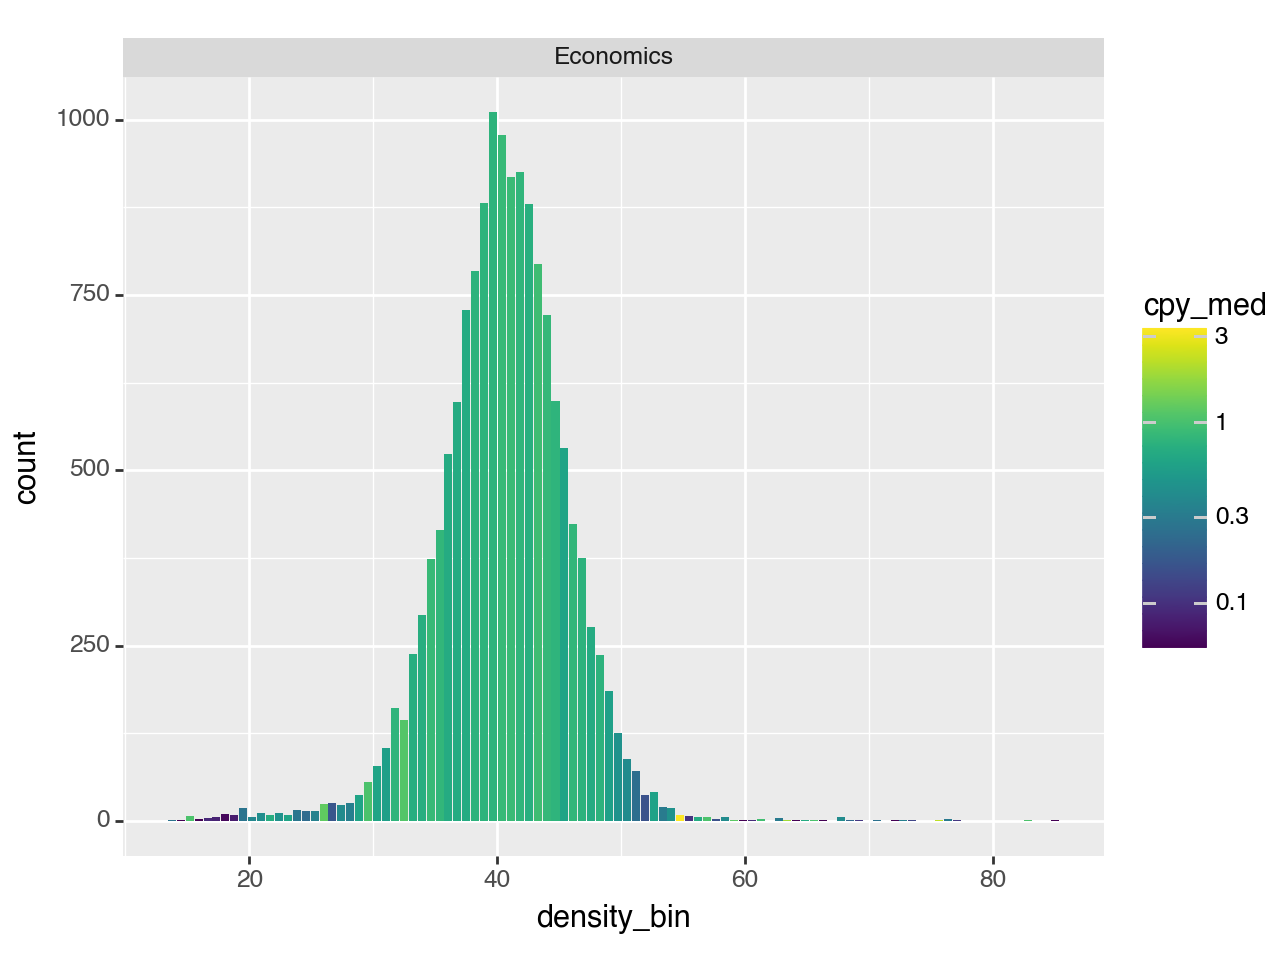

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


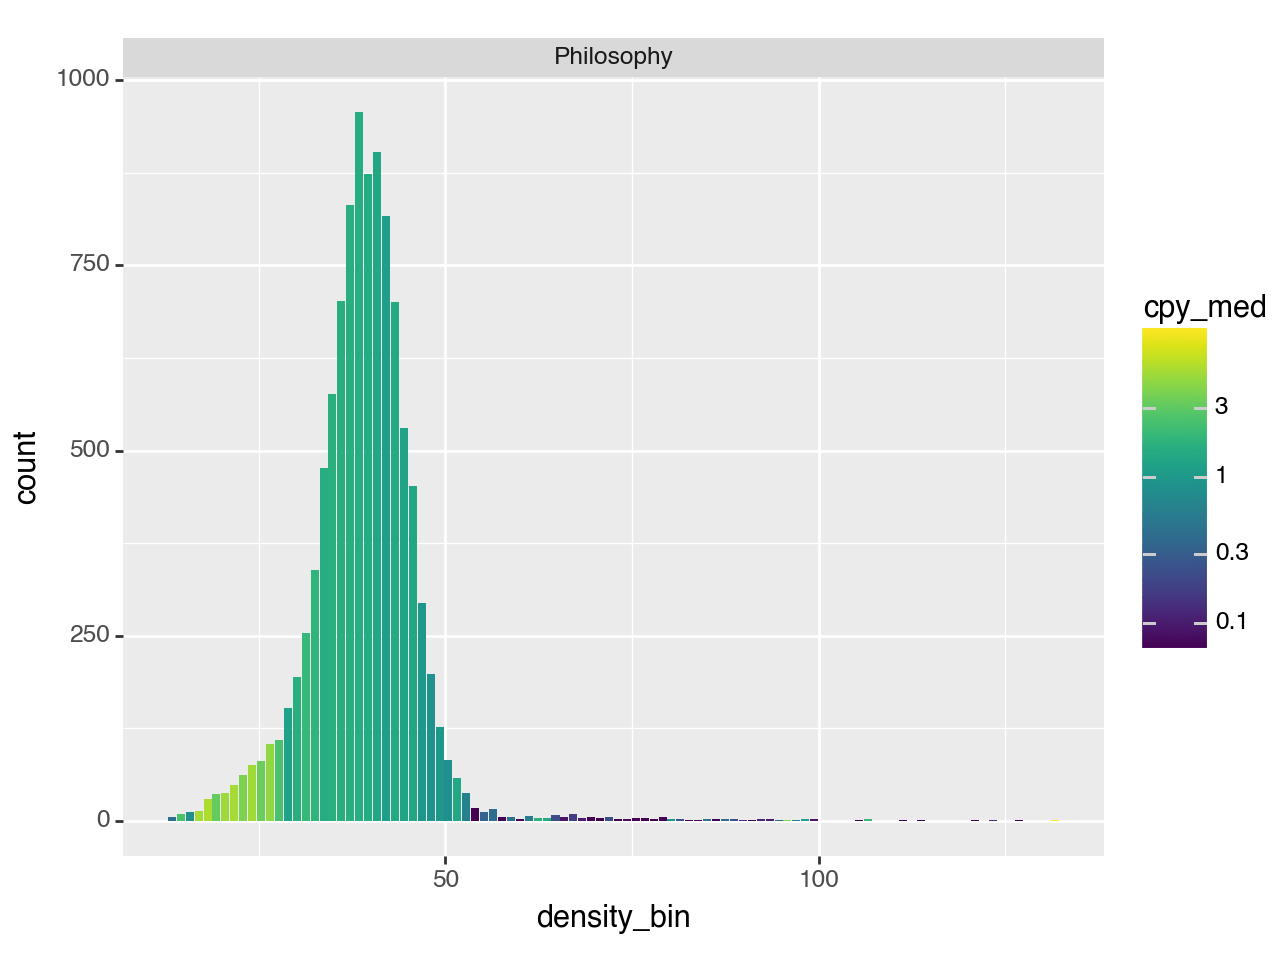

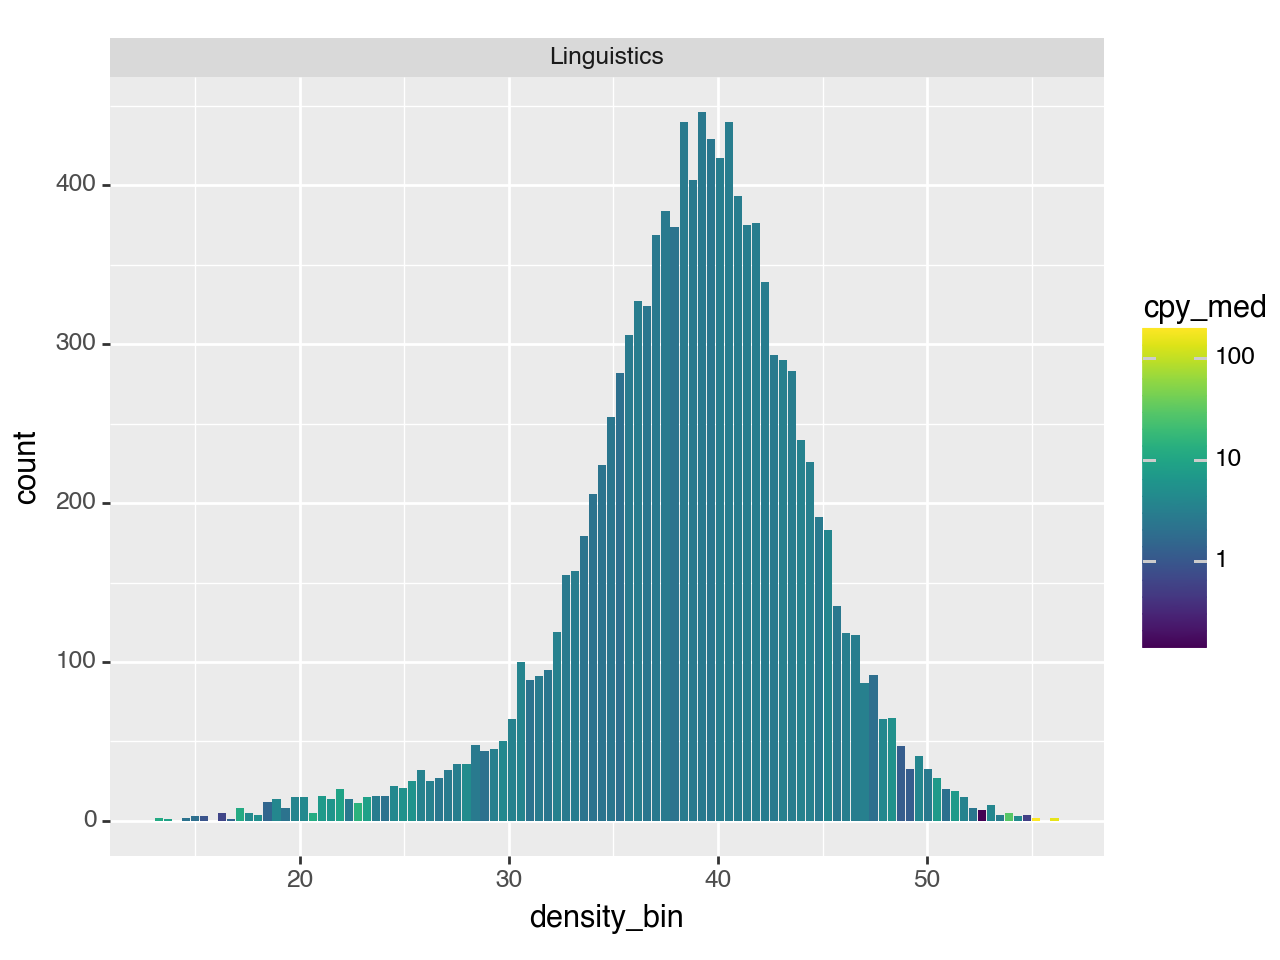

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


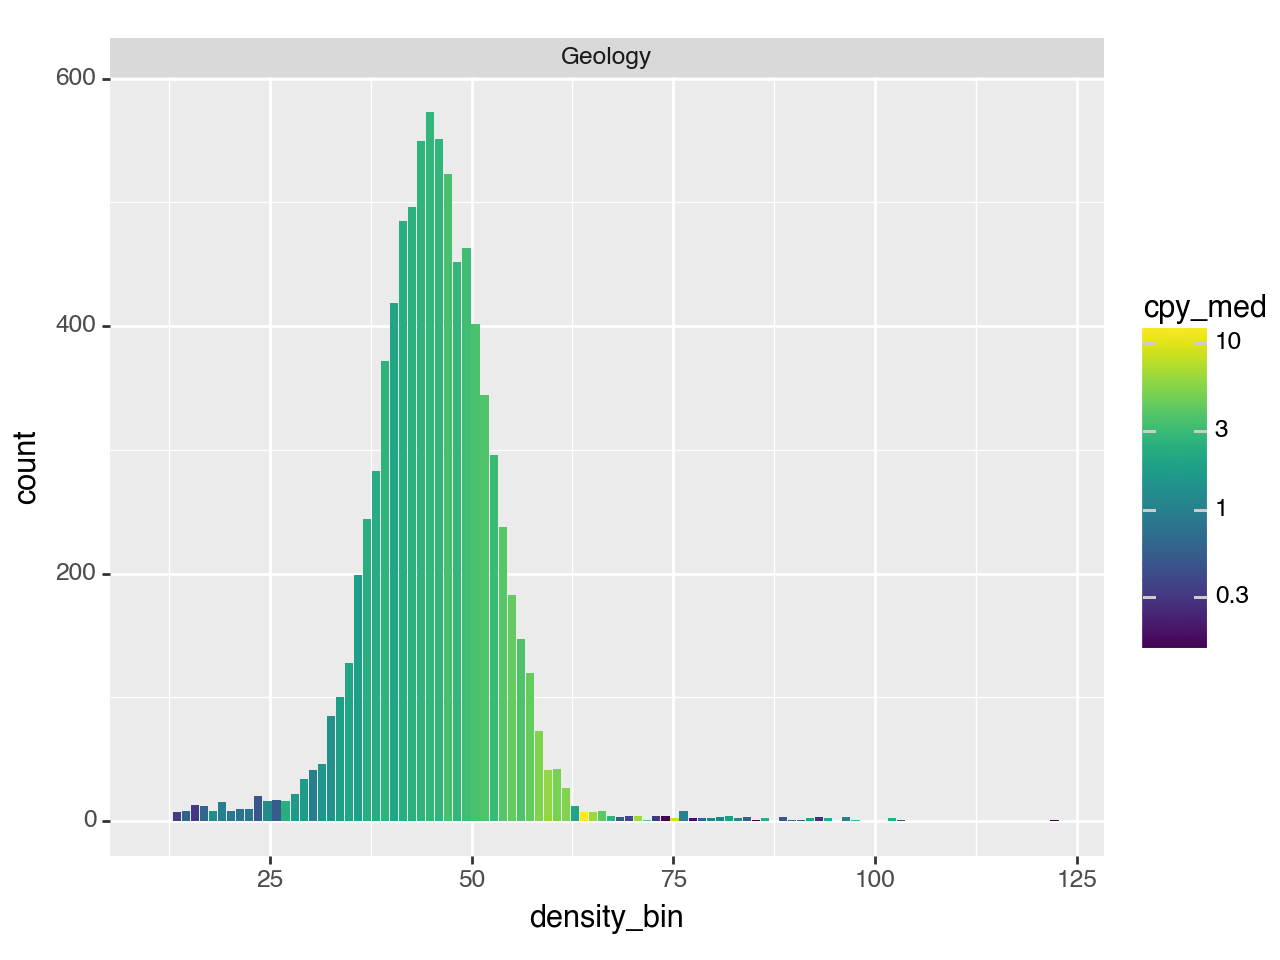

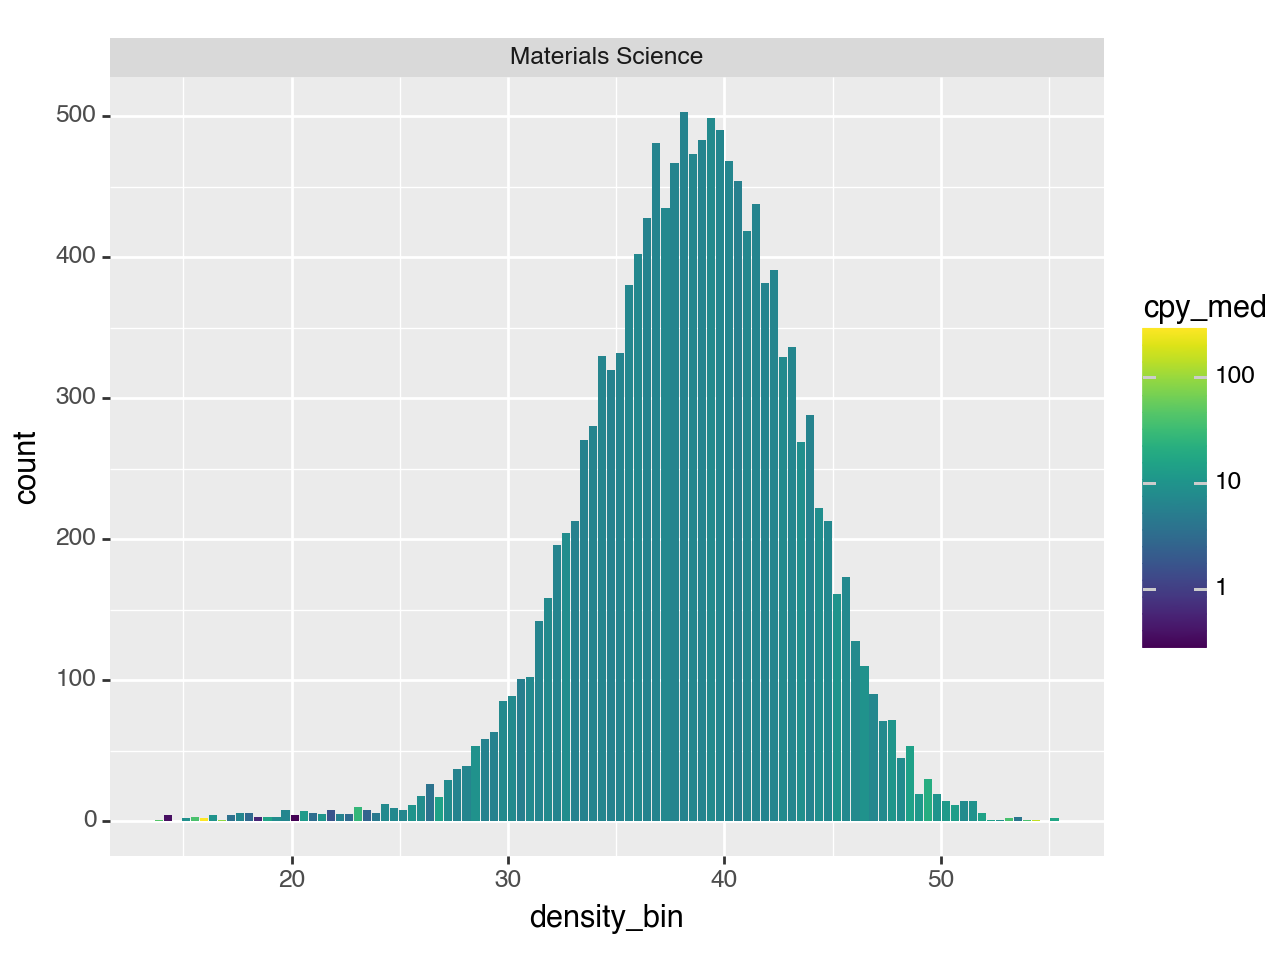

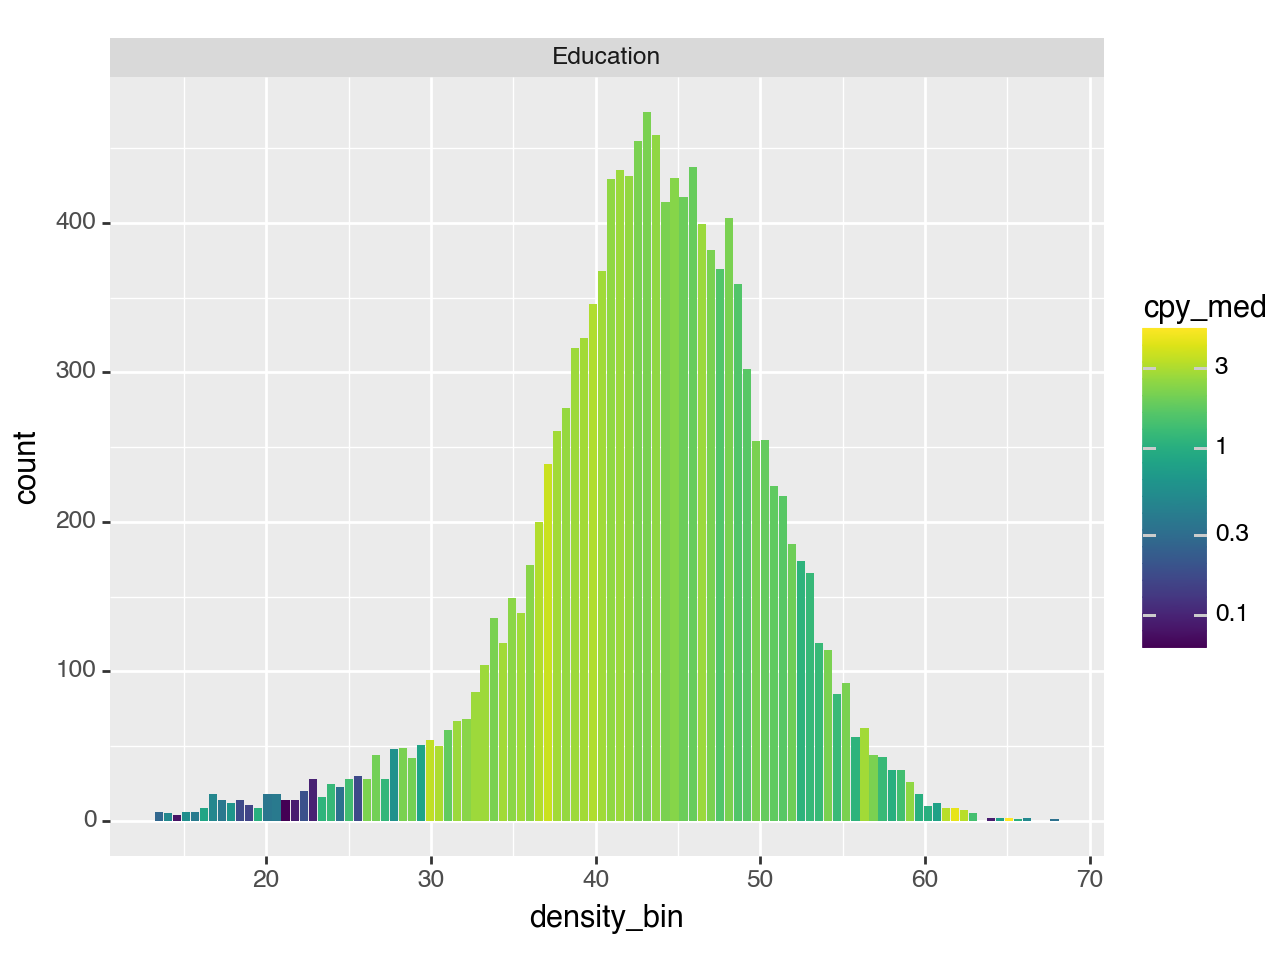

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


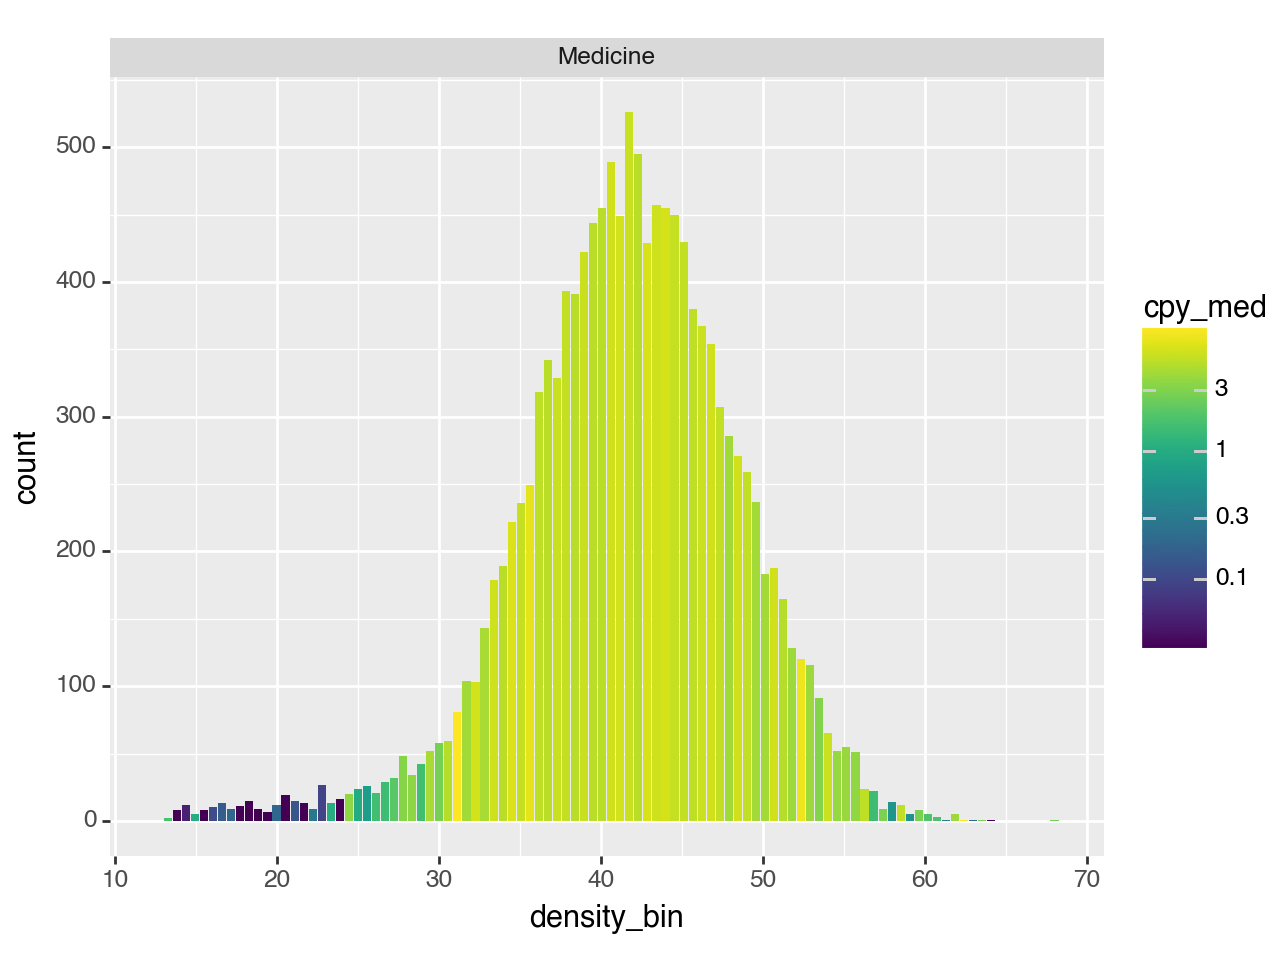

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


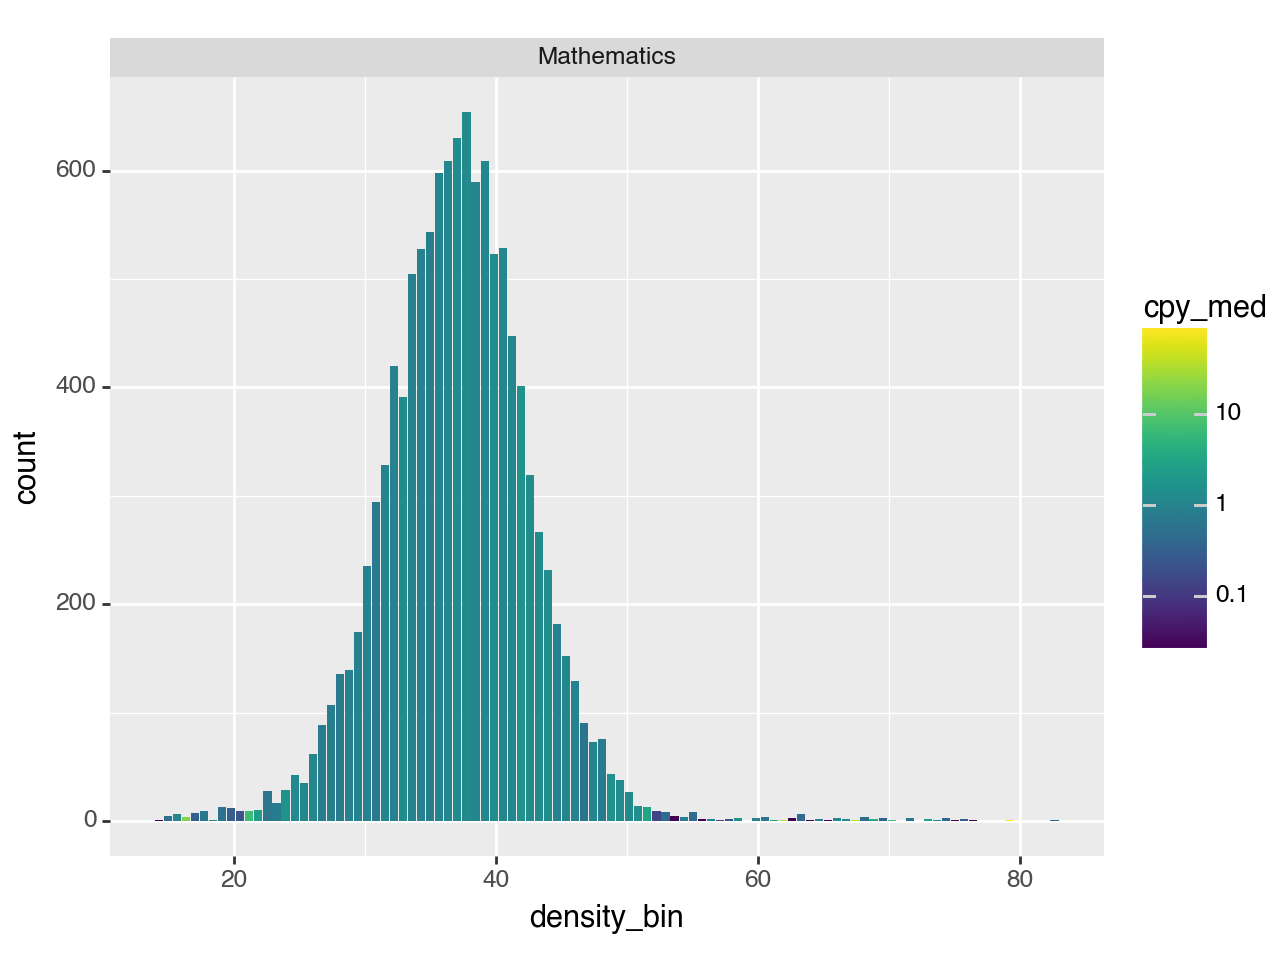

In [62]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            # fill="log_cpy variance",
            # fill="cpy_var",
            fill="cpy_med",
            # fill="log_cpy median",
            y="count",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
        + pn.scale_fill_continuous(trans = "log10")
    )


In [63]:
df_ent_all["log_cpy_variance"] = df_ent_all["log_cpy variance"]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/cit

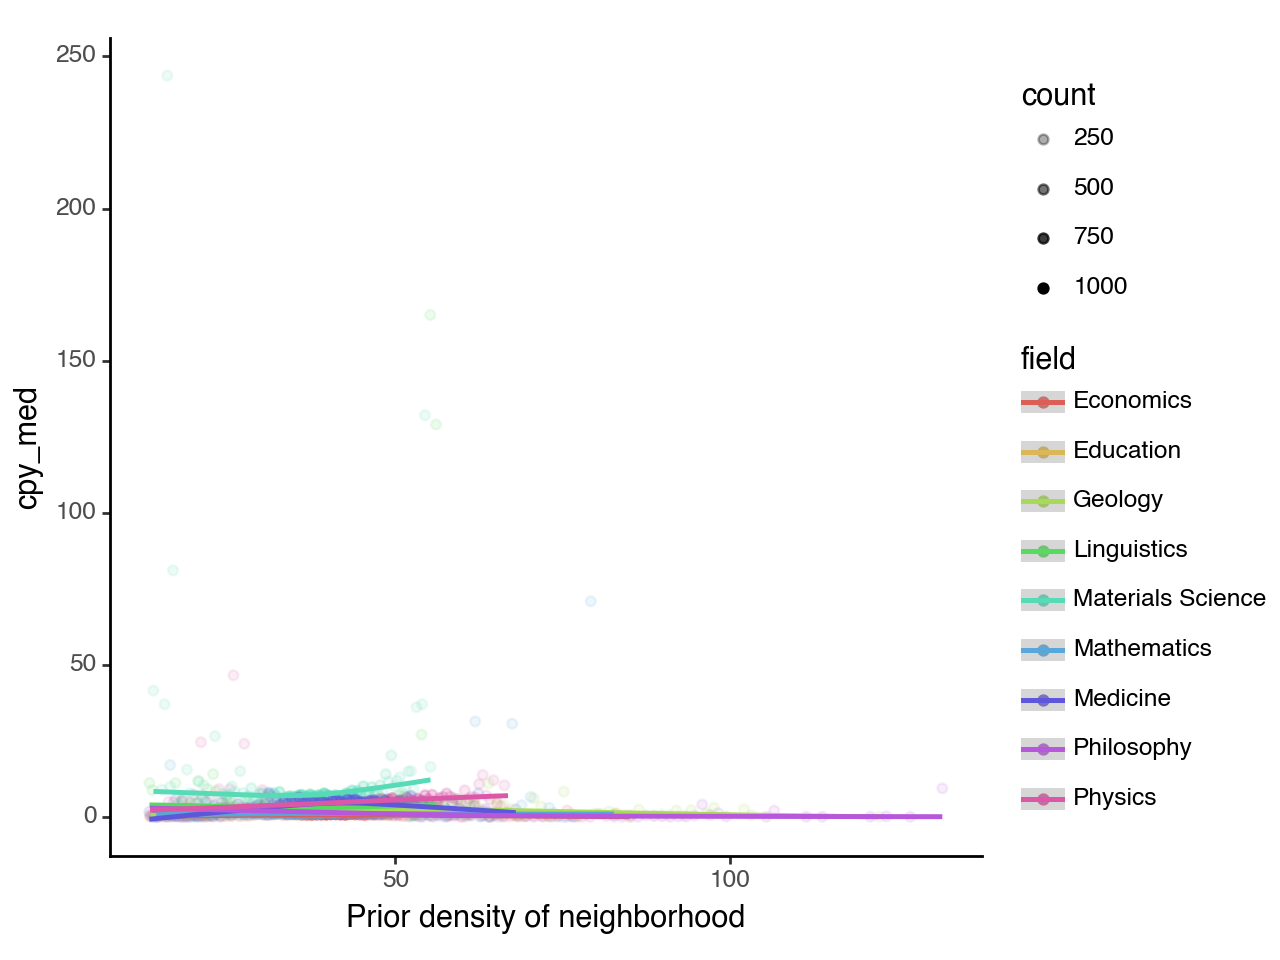

<Figure Size: (640 x 480)>

In [64]:
from scipy.stats import linregress

(
        pn.ggplot(
            df_ent_all[df_ent_all["count"] > 0], 
            pn.aes(
                x="density_bin",
                # y="log_cpy variance",
                y="cpy_med",
                color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                # size="freq",
                alpha="count",      
            )
        )
        + pn.geom_smooth(
            pn.aes(
                # color="field",
            ),
            # color="black",
        )
        # + pn.ylab("Variance in log citations per year")
        + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
)

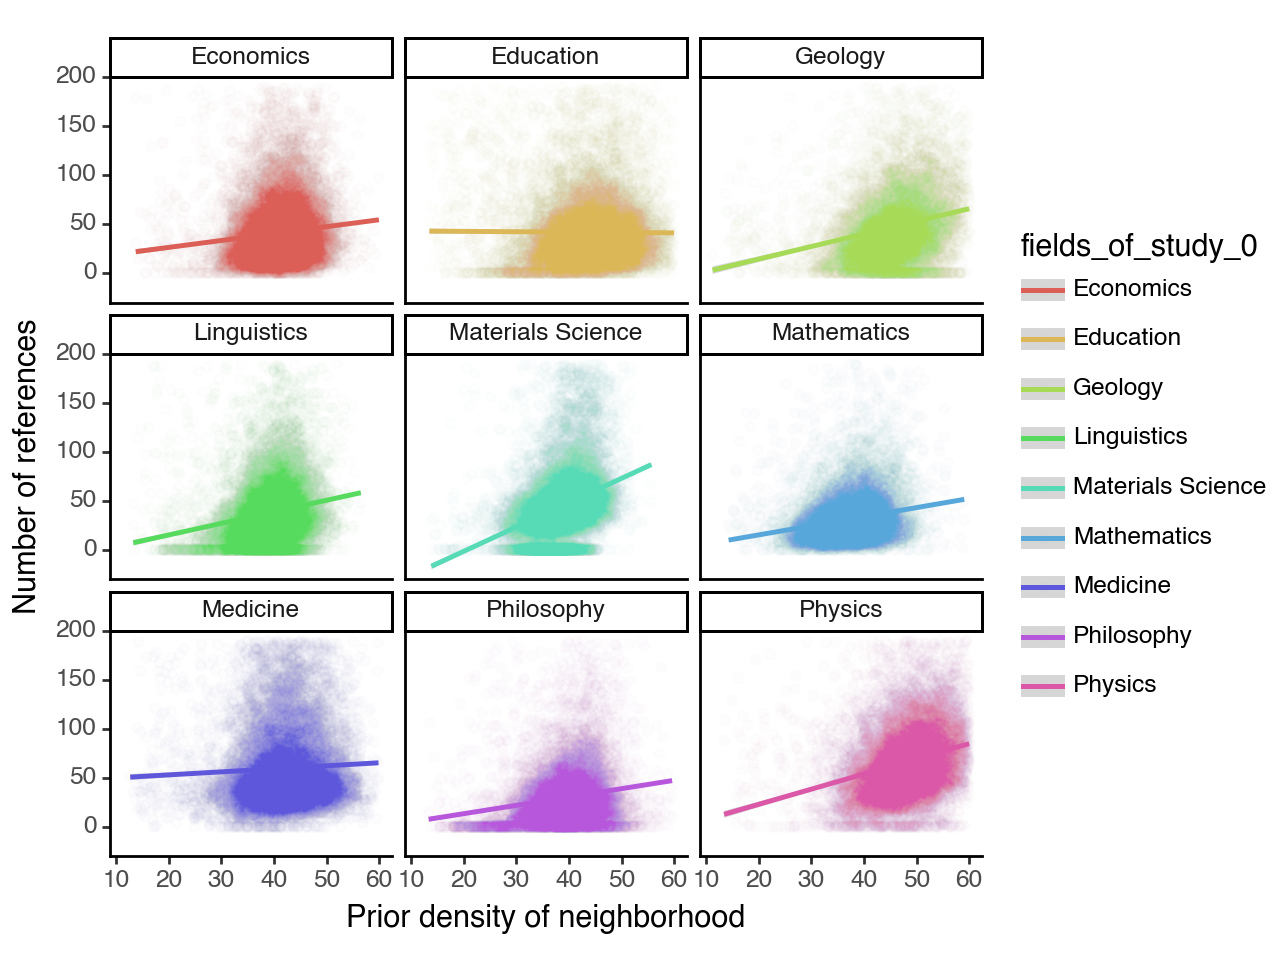

<Figure Size: (640 x 480)>

In [65]:
# Let's visualize reference length for all fields.

df_temp =  df[df["density"] < 60]
df_temp = df_temp[df_temp.references < (df_temp.references.mean())+2*df_temp.references.std()]

(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.xlab("Prior density of neighborhood")
    + pn.ylab("Number of references")
    + pn.theme_classic()
    # TODO: annotate each line with R^2, p-values
    # TODO: normalize each by the average number of references per field
)

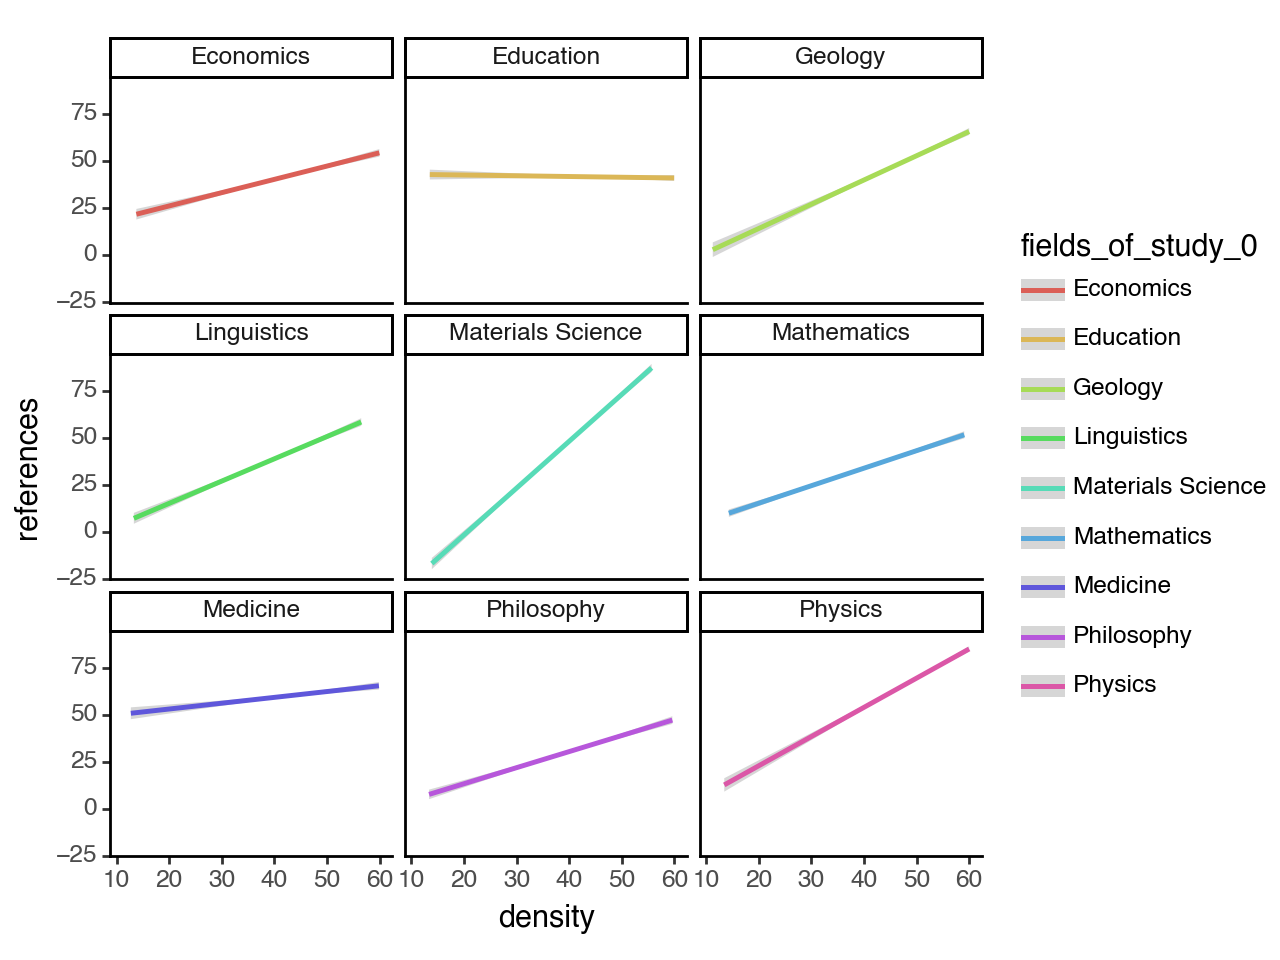

<Figure Size: (640 x 480)>

In [66]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            # x="references",
            # y="log_cpy",
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    # + pn.geom_point(alpha=0.01)
    # + pn.geom_hline( pn.aes(yintercept=df_temp.log_cpy.median().item()) )
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


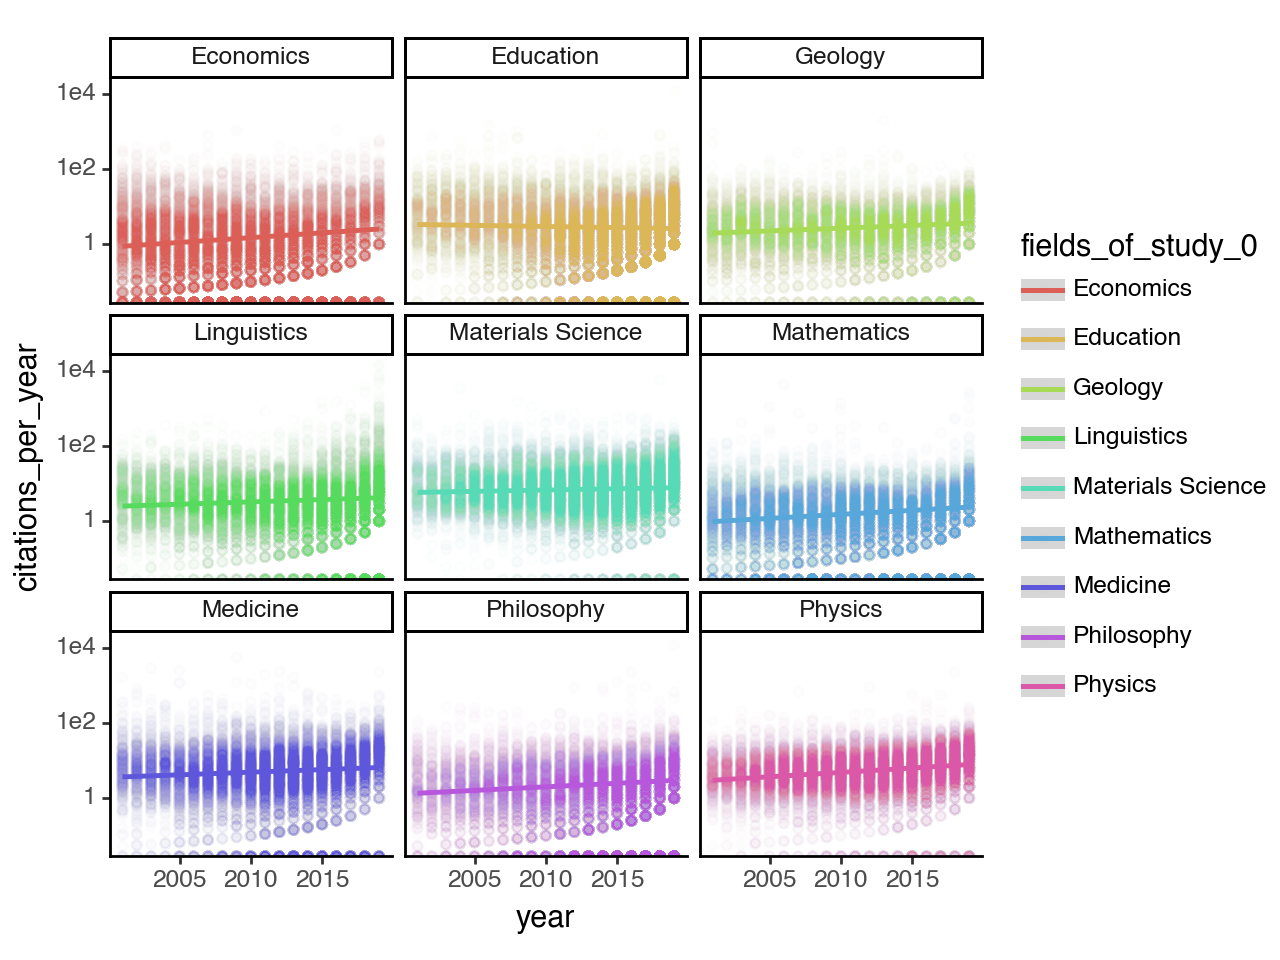

<Figure Size: (640 x 480)>

In [67]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="year",
            y="citations_per_year",
            color="fields_of_study_0",
        )
    )
    + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

In [68]:
# try in R, maybe its prettier.
# df_ent_all.to_csv(f"{vectorizer}_cpy_variance_data.csv", index=False)

In [69]:
df.year.value_counts()

year
2018    7553
2019    7376
2017    7372
2016    7285
2015    7272
2014    7163
2013    7071
2012    6728
2011    6333
2010    5906
2009    5463
2008    5250
2007    4847
2006    4459
2005    4202
2004    3804
2003    3562
2002    3159
2001    2824
Name: count, dtype: int64

#### Zach style main trend plot from ads paper

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

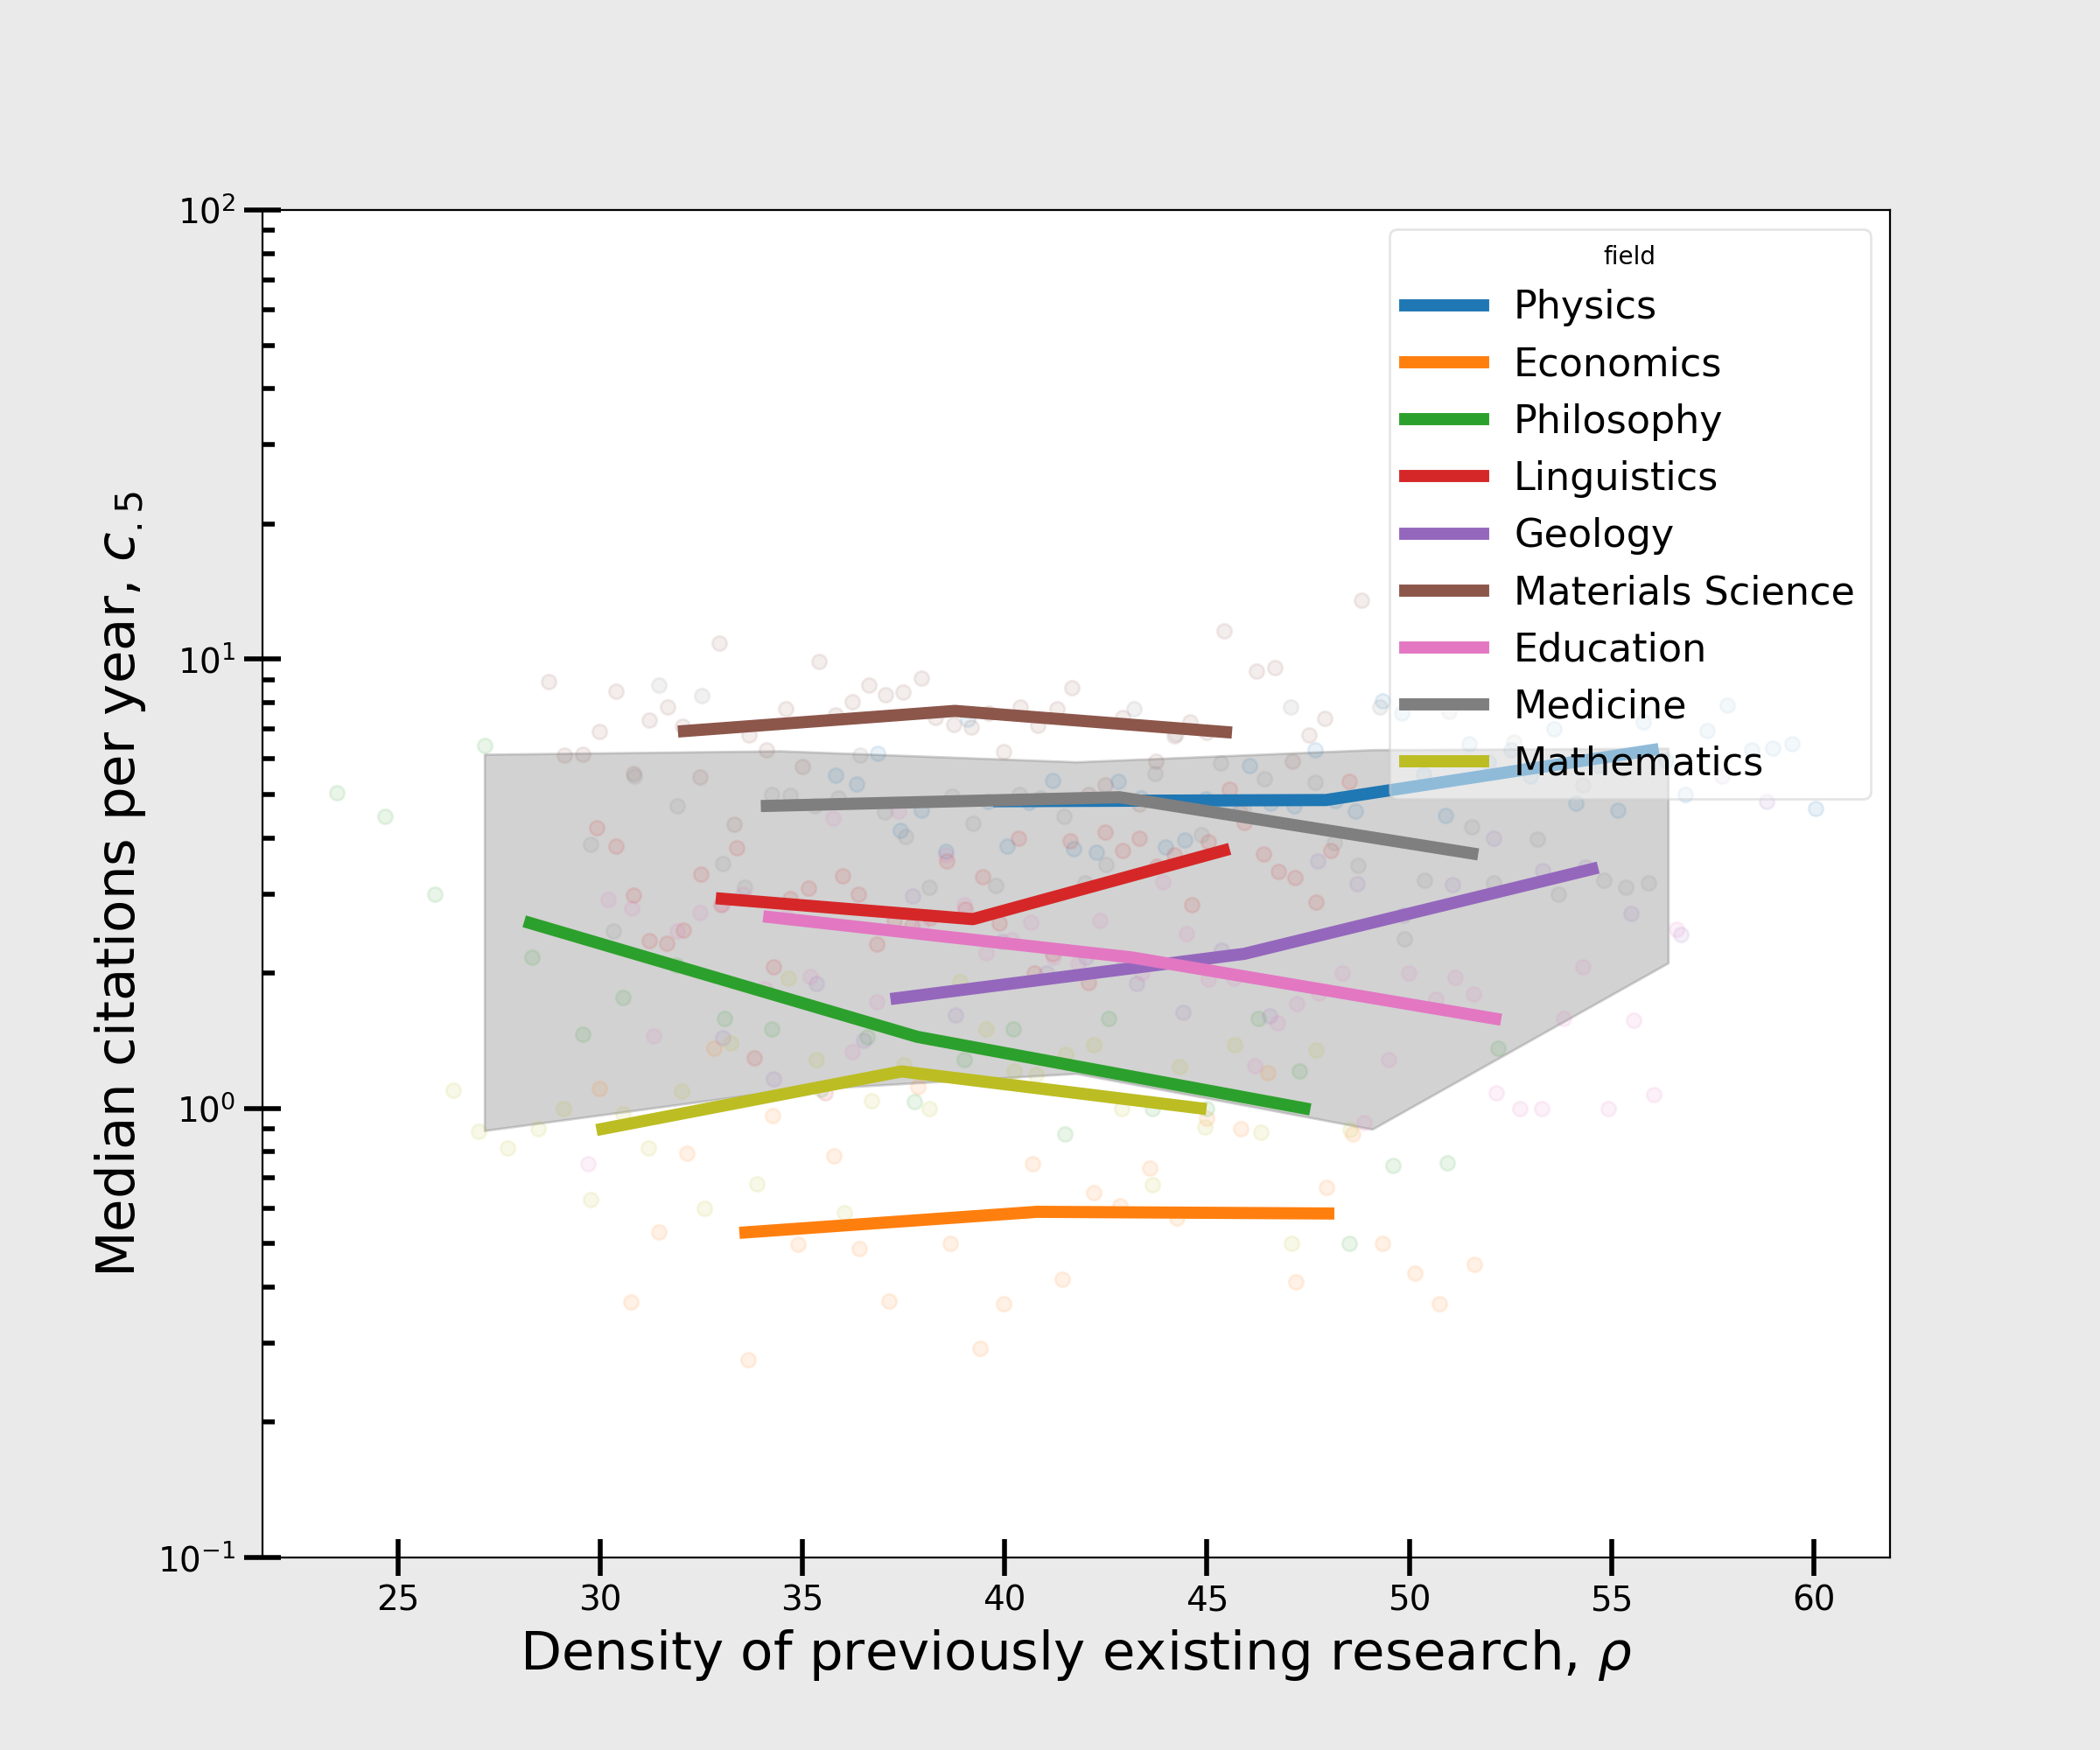

In [70]:
import matplotlib
import matplotlib.pyplot as plt
import scipy


# df_mpl = pd.read_csv("dmb_vs_log_cpy_var.csv")
df_mpl = pd.concat(
    [get_df_var(df, field, n_bin=50)
    for field in df["fields_of_study_0"].unique()],
)


facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()

e_n = df_mpl["density_med_bin"]

mult = 1.

cpy_v = df_mpl["cpy_med_bin"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    6,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# add fields
fields = df_mpl.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_mpl[df_mpl["field"] == field]

    e_n = df_field["density_med_bin"]

    cpy_v = df_field["cpy_med_bin"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor,
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_yscale( 'log' )
ax.set_ylim(0.1, 100)

# Axis labels
# ax.set_ylabel( r'Variance in citations per year, $\sigma^2$', fontsize=22 )
ax.set_ylabel( r'Median citations per year, $c_{.5}$', fontsize=22 )
ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Because the plotting data involves sampling, there are a lot of spurious researcher degrees of freedom in selecting which trends to show! Because some of these fields are only slighltly decreasing in variance, esp economics, and linguistics, it's important to reflect that, but it's also important to not just sample the best looking plot for our story. Need some more principled way of plotting the relationship.

In [71]:
df_ent_new = pd.concat(
    [get_df_ent(df, field, num_bins=1000)
    for field in df_all["fields_of_study_0"].unique()],
)

df_ent_new = df_ent_new[df_ent_new["count"] > 10]
df_ent_new["log_cpy_var"] = df_ent_new["log_cpy variance"]
df_ent_new.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/numpy/lib/nanfunc

density_bin     freq  count  log_cpy entropy  log_cpy variance  \
420       36.074  0.00117     13       254.243486          0.588999   
424       36.289  0.00099     11       568.496708          0.171130   
434       36.829  0.00099     11              NaN          0.054234   
438       37.045  0.00126     14              NaN          0.296512   
441       37.207  0.00099     11       287.756612          0.534824   

     log_cpy median     cpy_var   cpy_med   cpy_mean  ref_med       ref_var  \
420        0.364699  737.901519  2.315789  11.949722     46.0    478.686391   
424        0.903090   59.475002  8.000000  10.657202     54.0   3361.537190   
434        0.772034   54.506083  5.600000   7.866690     38.0  12081.652893   
438        0.844669  103.245203  6.073529   8.470256     37.0   1454.346939   
441        0.243038  156.203785  1.750000   9.180231     55.0   3588.793388   

     year_med    field  log_cpy_var  
420    2008.0  Physics     0.588999  
424    2013.0  Physics     0.171130  
434    2006.0  Physics     0.054234  
438    2005.5  Physics     0.296512  
441    2011.0  Physics     0.534824

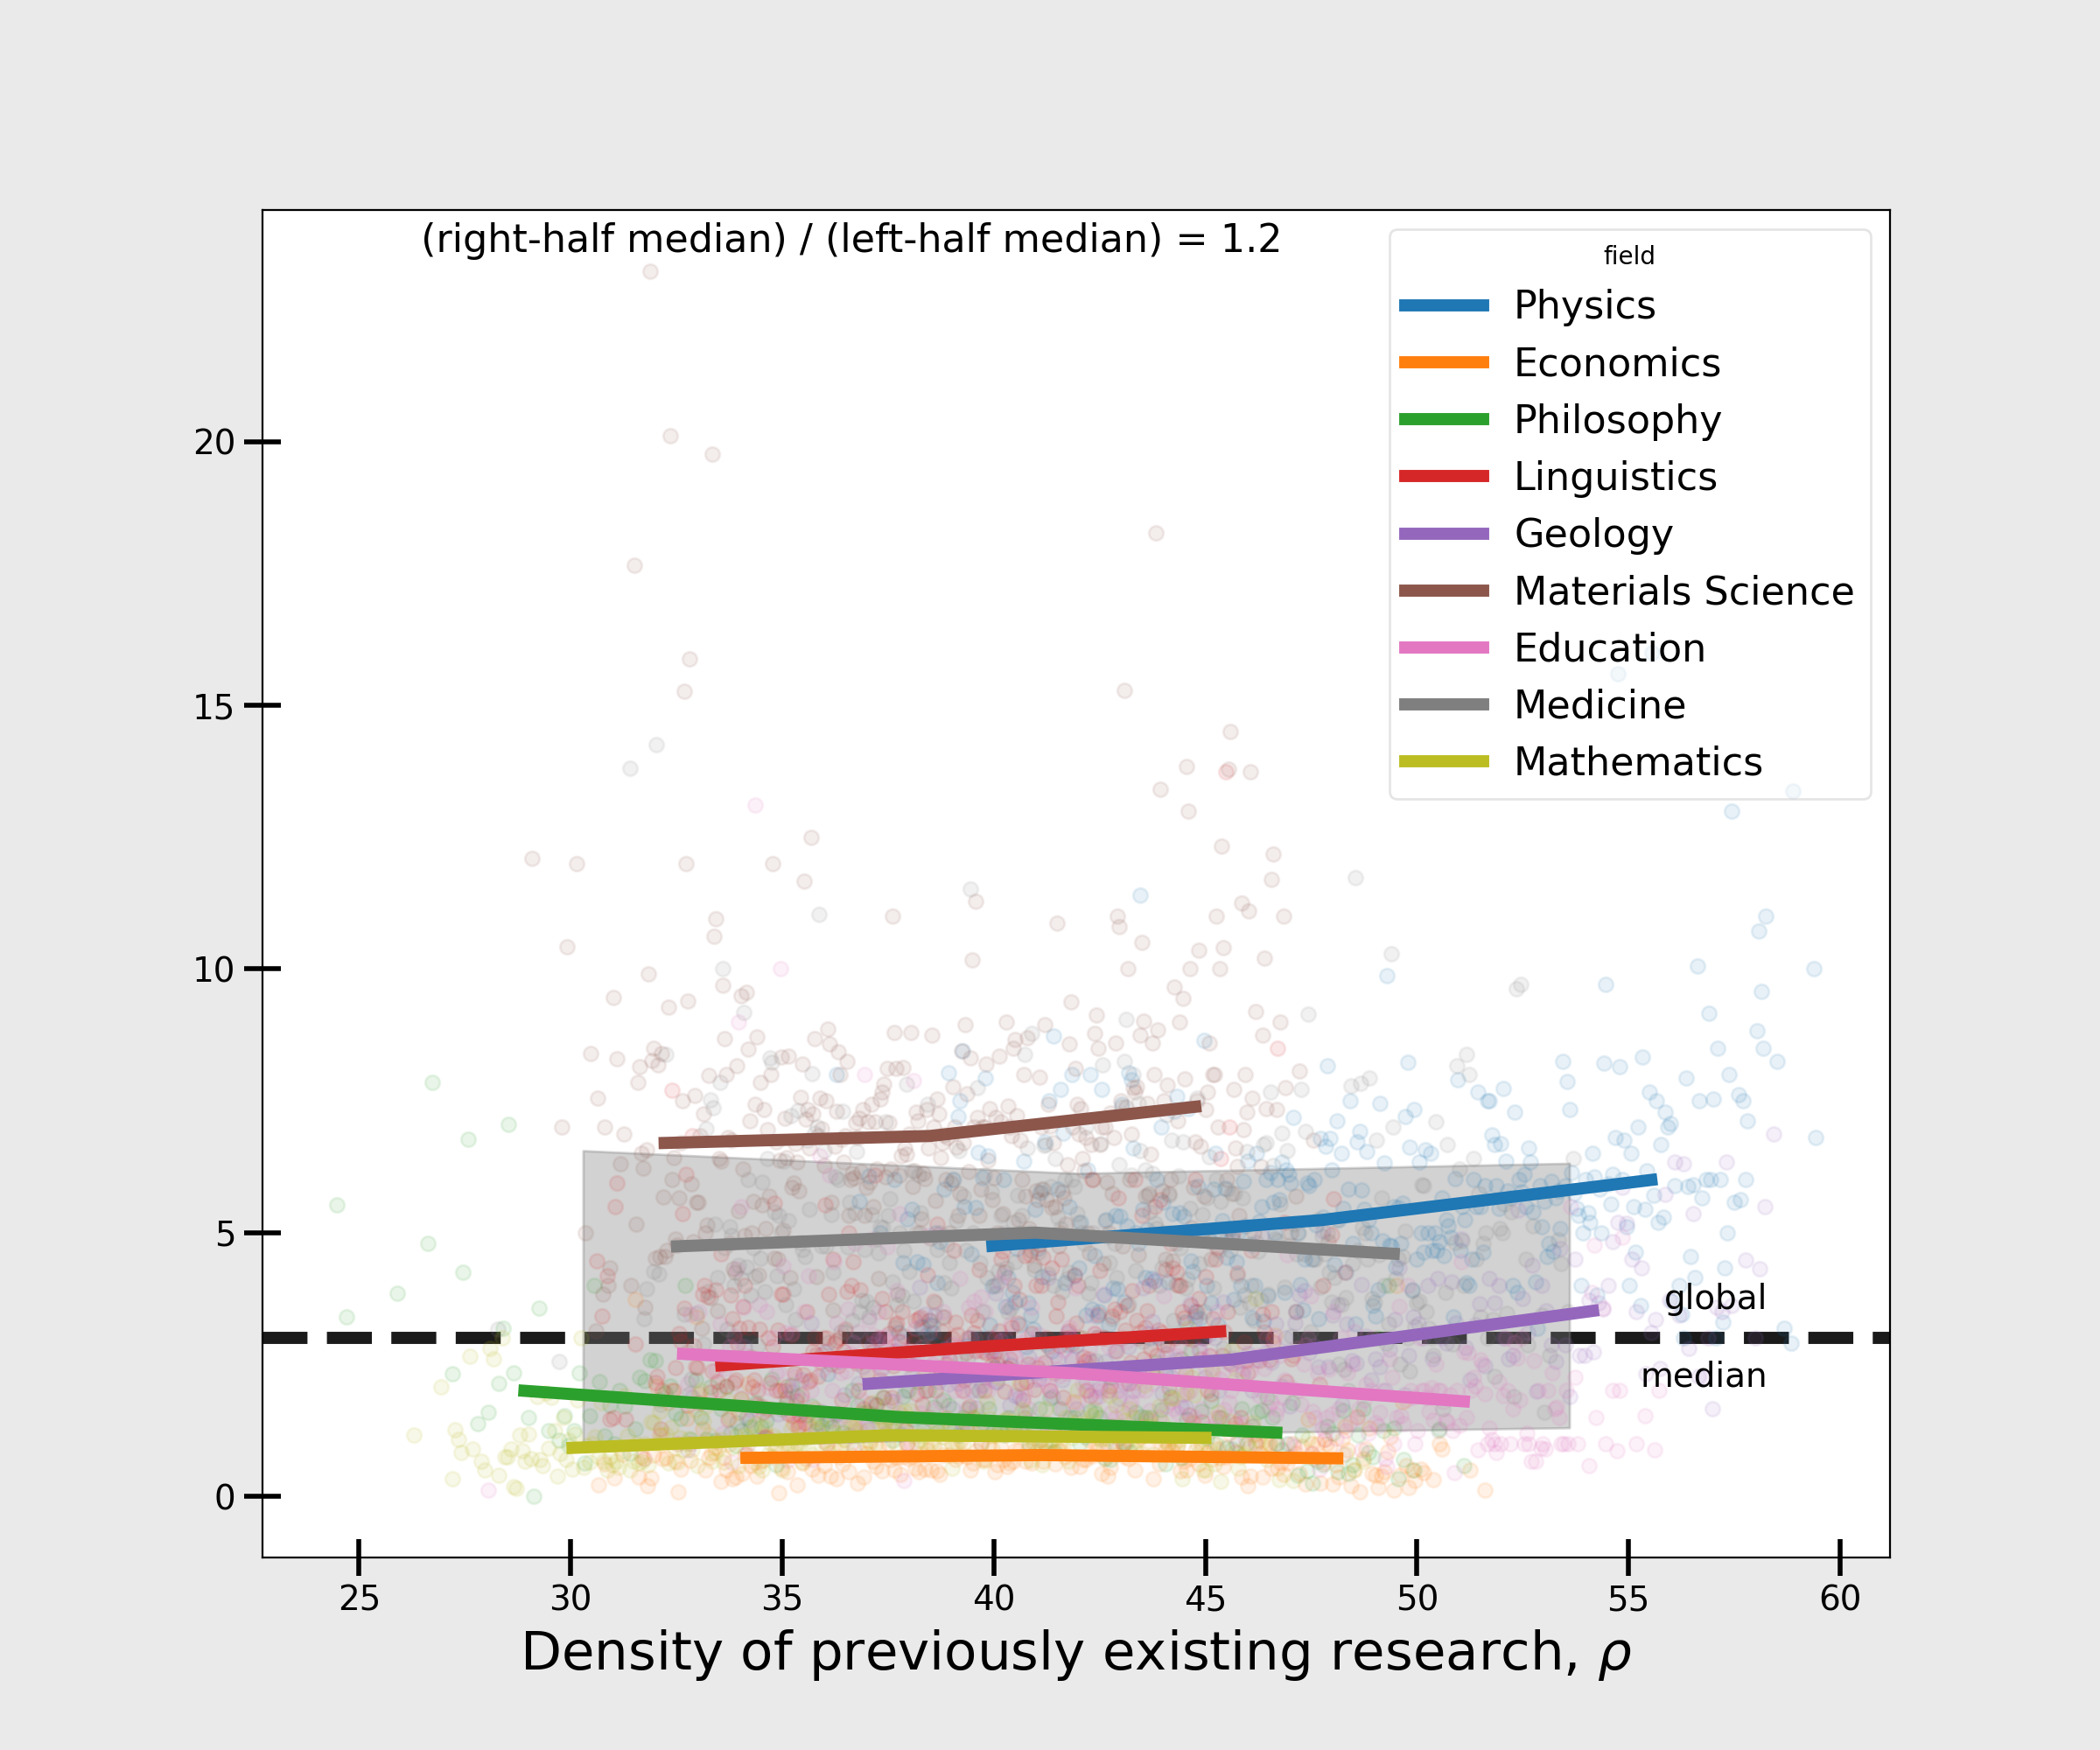

In [72]:
facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()


e_n = df_ent_new["density_bin"]

mult = 1.

cpy_v = df_ent_new["cpy_med"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    4,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# Global median number of citations (baseline)
global_median = np.nanpercentile( cpy_v, 50. )
ax.axhline(
    global_median,
    color = '0.1',
    linestyle = '--',
    linewidth = 5,
    zorder = -100,
)
ax.annotate(
    text = 'global\n\nmedian',
    xy = (bin_edges[-1], global_median),
    xycoords = 'data',
    xytext = (-20, 0),
    textcoords = 'offset points',
    va = 'center',
    ha = 'right',
    fontsize = 14,
)

# Summary statistics  
top_half = e_n > np.nanmean( e_n )
cpy_top = cpy_v[top_half]
cpy_bottom = cpy_v[np.invert(top_half)]
cpy_mult = np.nanmedian( cpy_top ) / np.nanmedian( cpy_bottom )
frac_below = ( cpy_top < global_median ).sum() / cpy_top.size
s = (
    r' (right-half median) / (left-half median) =' +
    ' {:.2g}'.format( cpy_mult ) #+
)
values = ax.annotate(
    text = s,
    xy = (1, 1),
    xycoords = 'axes fraction',
    xytext = (-250, -5),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 16,
)

# add fields
fields = df_ent_new.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_ent_new[df_ent_new["field"] == field]

    e_n = df_field["density_bin"]

    cpy_v = df_field["cpy_med"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)

# ax.set_yscale( 'log' )
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(False)

# ax.set_ylim(0,10)
# ax.set_ylim(0.1,0.8)
# ax.set_xlim(25,50)
# ax.set_ylim(0.1,100)

# Axis labels
# ax.set_ylabel( r'Variance in citations per year, $\sigma_{c}^2$', fontsize=22 )
# ax.set_ylabel( r'Median citations per year, $c_{cpy}$', fontsize=22 )

ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Can we make double figure like og ads paper?

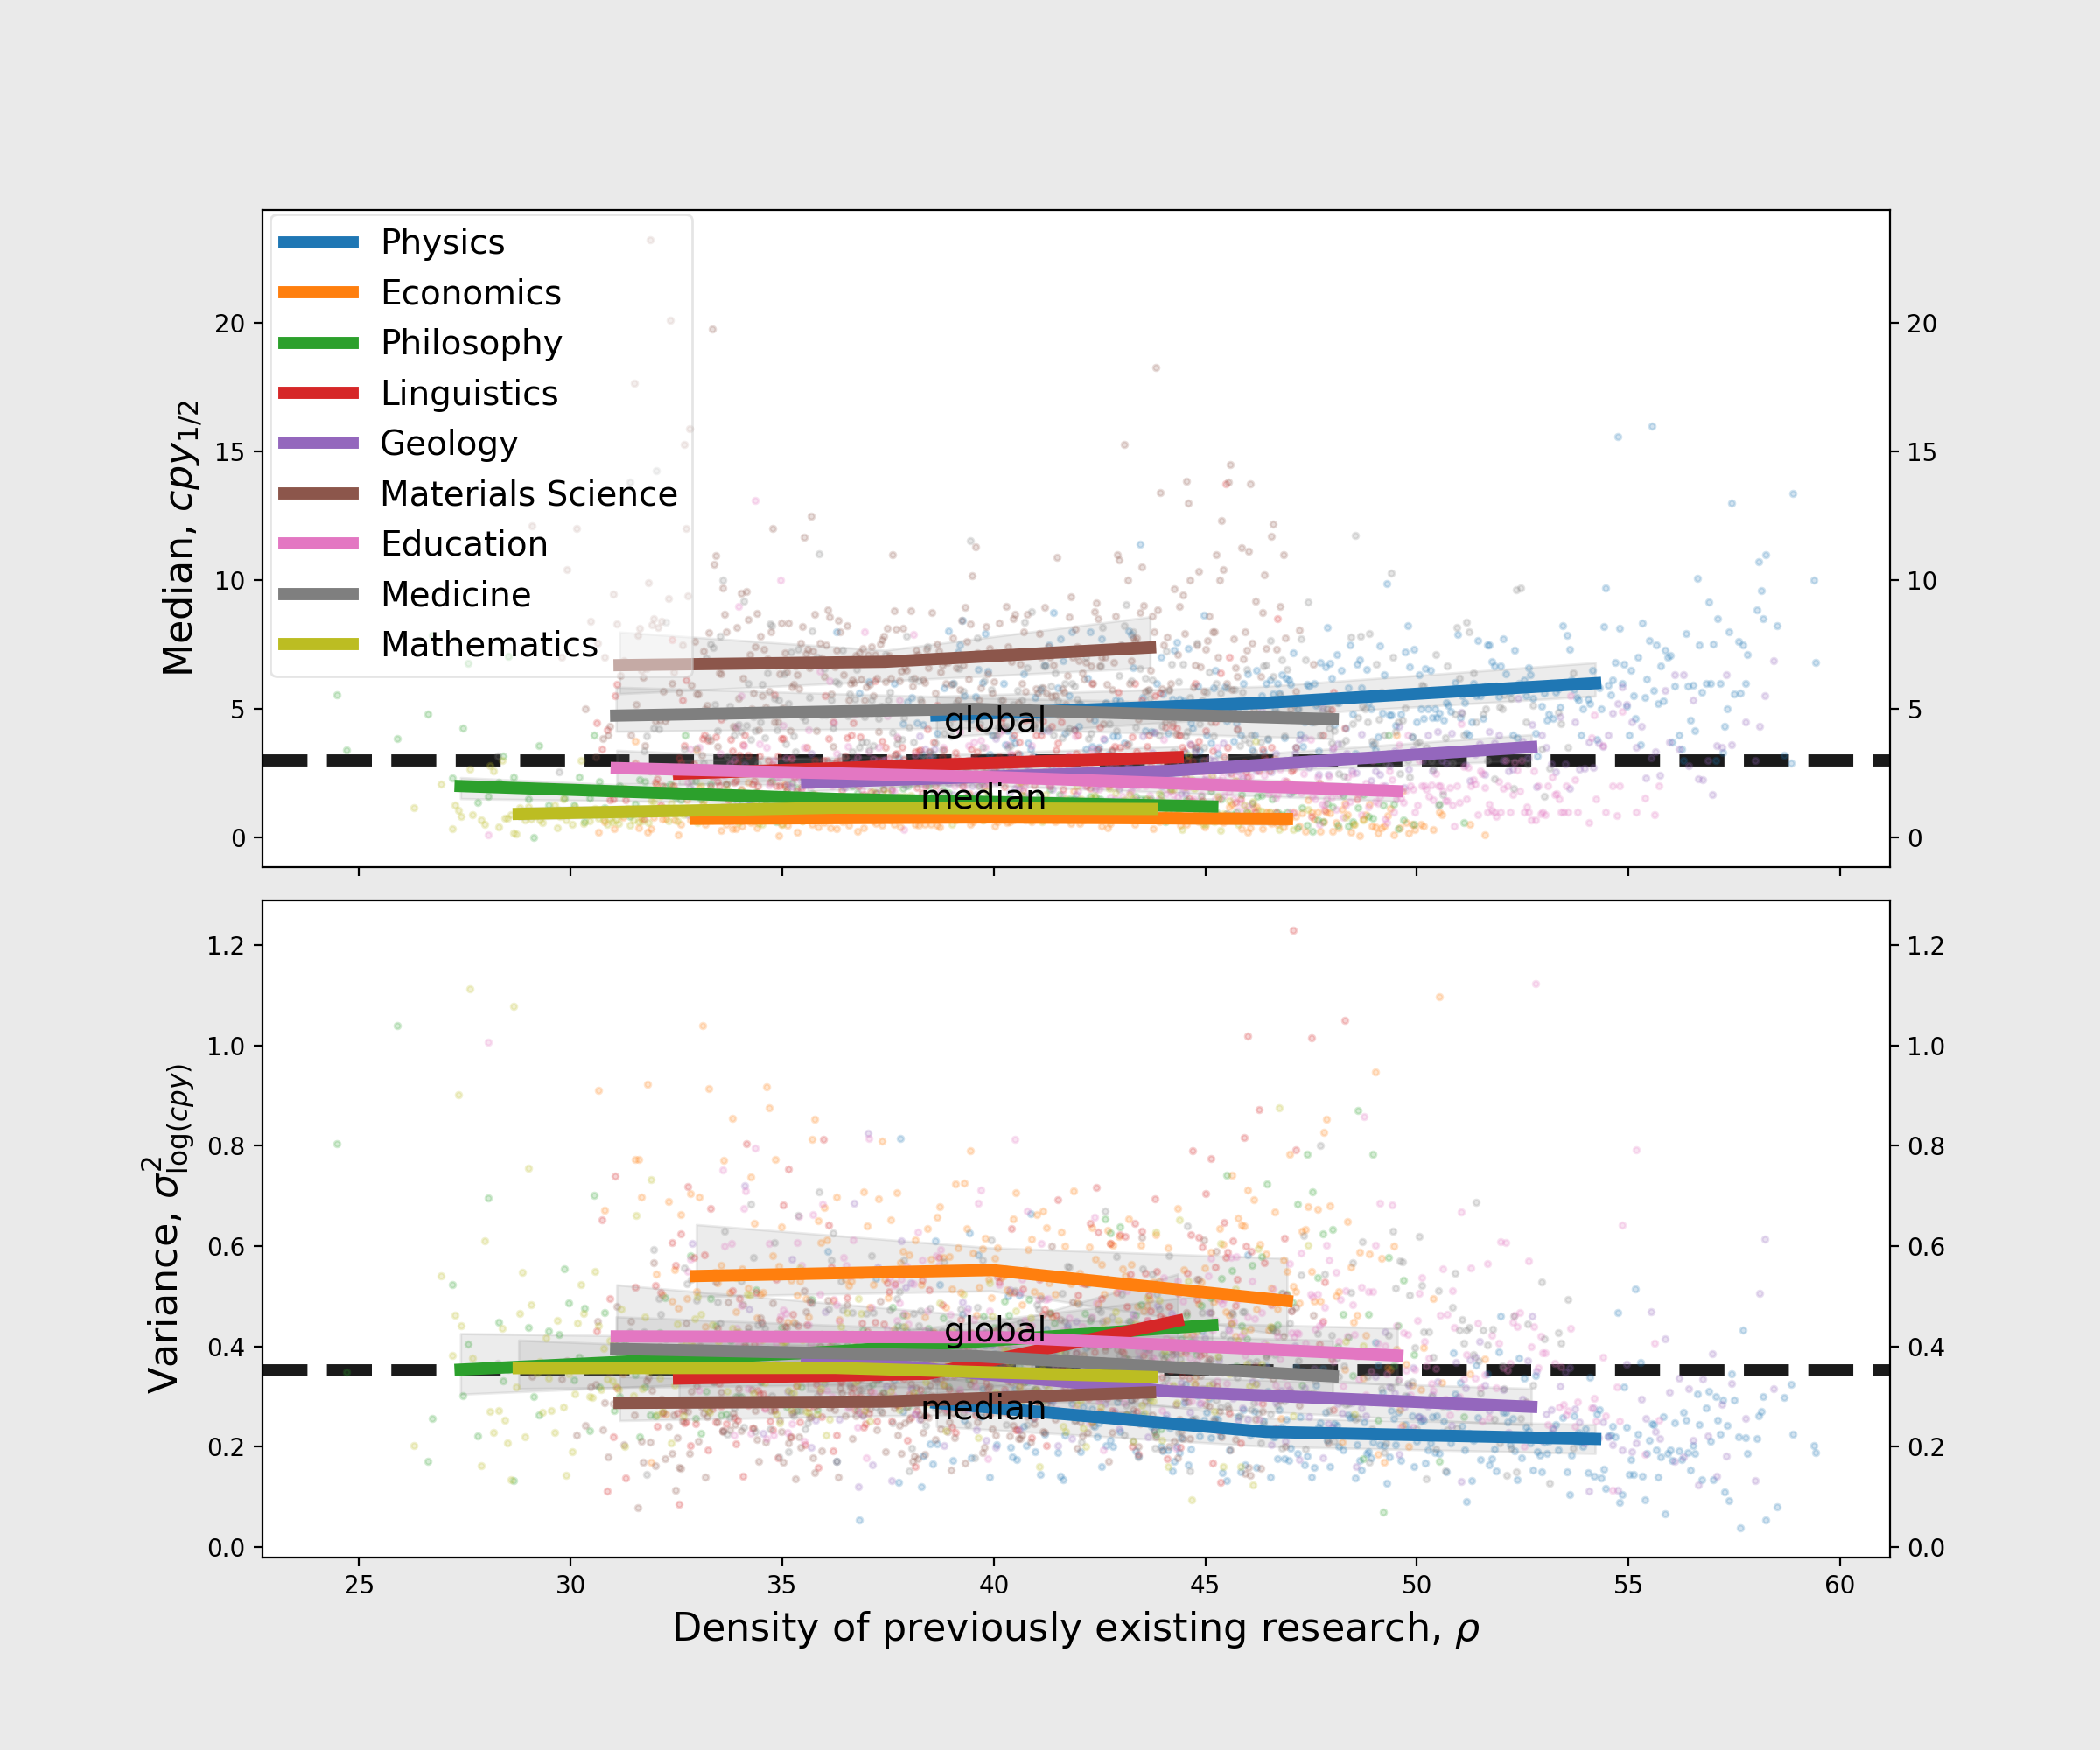

In [73]:
import warnings
import matplotlib.gridspec as gridspec


df_plot = df_ent_new

# df_plot = pd.concat(
#     [get_df_var(df, field, n_bin=20)
#     for field in df["fields_of_study_0"].unique()],
# )


rows = ["median", "variance"]
n_rows = 2

fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )
# ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "density_bin"
# x_variable = "density_med_bin"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "log_cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    # GLobal

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    # median, bin_edges, _ = scipy.stats.binned_statistic( x_observations, y_observations, 'median', bins=bin_edges )
    # ax.plot(
    #     mult * xs,
    #     median,
    #     linewidth = 10,
    #     color = "black",
    # )    


    # Global median number of citations (baseline)
    global_median = np.nanpercentile( y_observations, 50. )
    ax.axhline(
        global_median,
        color = '0.1',
        linestyle = '--',
        linewidth = 5,
        zorder = -100,
    )
    ax.annotate(
        text = 'global\n\nmedian',
        xy = (bin_edges[-2], global_median),
        xycoords = 'data',
        xytext = (0, 0),
        textcoords = 'offset points',
        va = 'center',
        ha = 'right',
        fontsize = 14,
    )    


    #######################################
    # Fields
    #######################################      

    fields = df_ent_new.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_field = df_plot[df_plot["field"] == field]

        x_observations_field = df_field[x_variable]
        y_observations_field = df_field[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            4,
        )

        xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 68 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 32 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            mult * xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            mult * x_observations_field,
            y_observations_field,
            alpha = 0.2,
            s=6,
            # label=field,
        )    

        ax.plot(
            mult * xs,
            median,
            linewidth = 5,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)                
        # ax.set_xlim(22,47)        
        # ax.set_ylim(0,11)
        ax.set_ylabel( r'Median, ${cpy}_{1/2}$', fontsize=16 )

        # Customize ticks
        # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
        # ax.tick_params( which='minor', direction='in', size=0, width=2, )


    if row == "variance":
        # ax.set_yscale( 'log' )
        # ax.set_ylim(10,1e4)
        # ax.set_xlim(22,47)
        # ax.set_ylim(0,1.,)
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)        

        ax.set_ylabel( r'Variance, $\sigma_{\log(cpy)}^2$', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.62, axbox.y0 + 0.2),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=16 )

# plt.tight_layout()

plt.show()


In [74]:
df_plot.to_csv(f"{vectorizer}_main_data.csv", index=False)

#### References

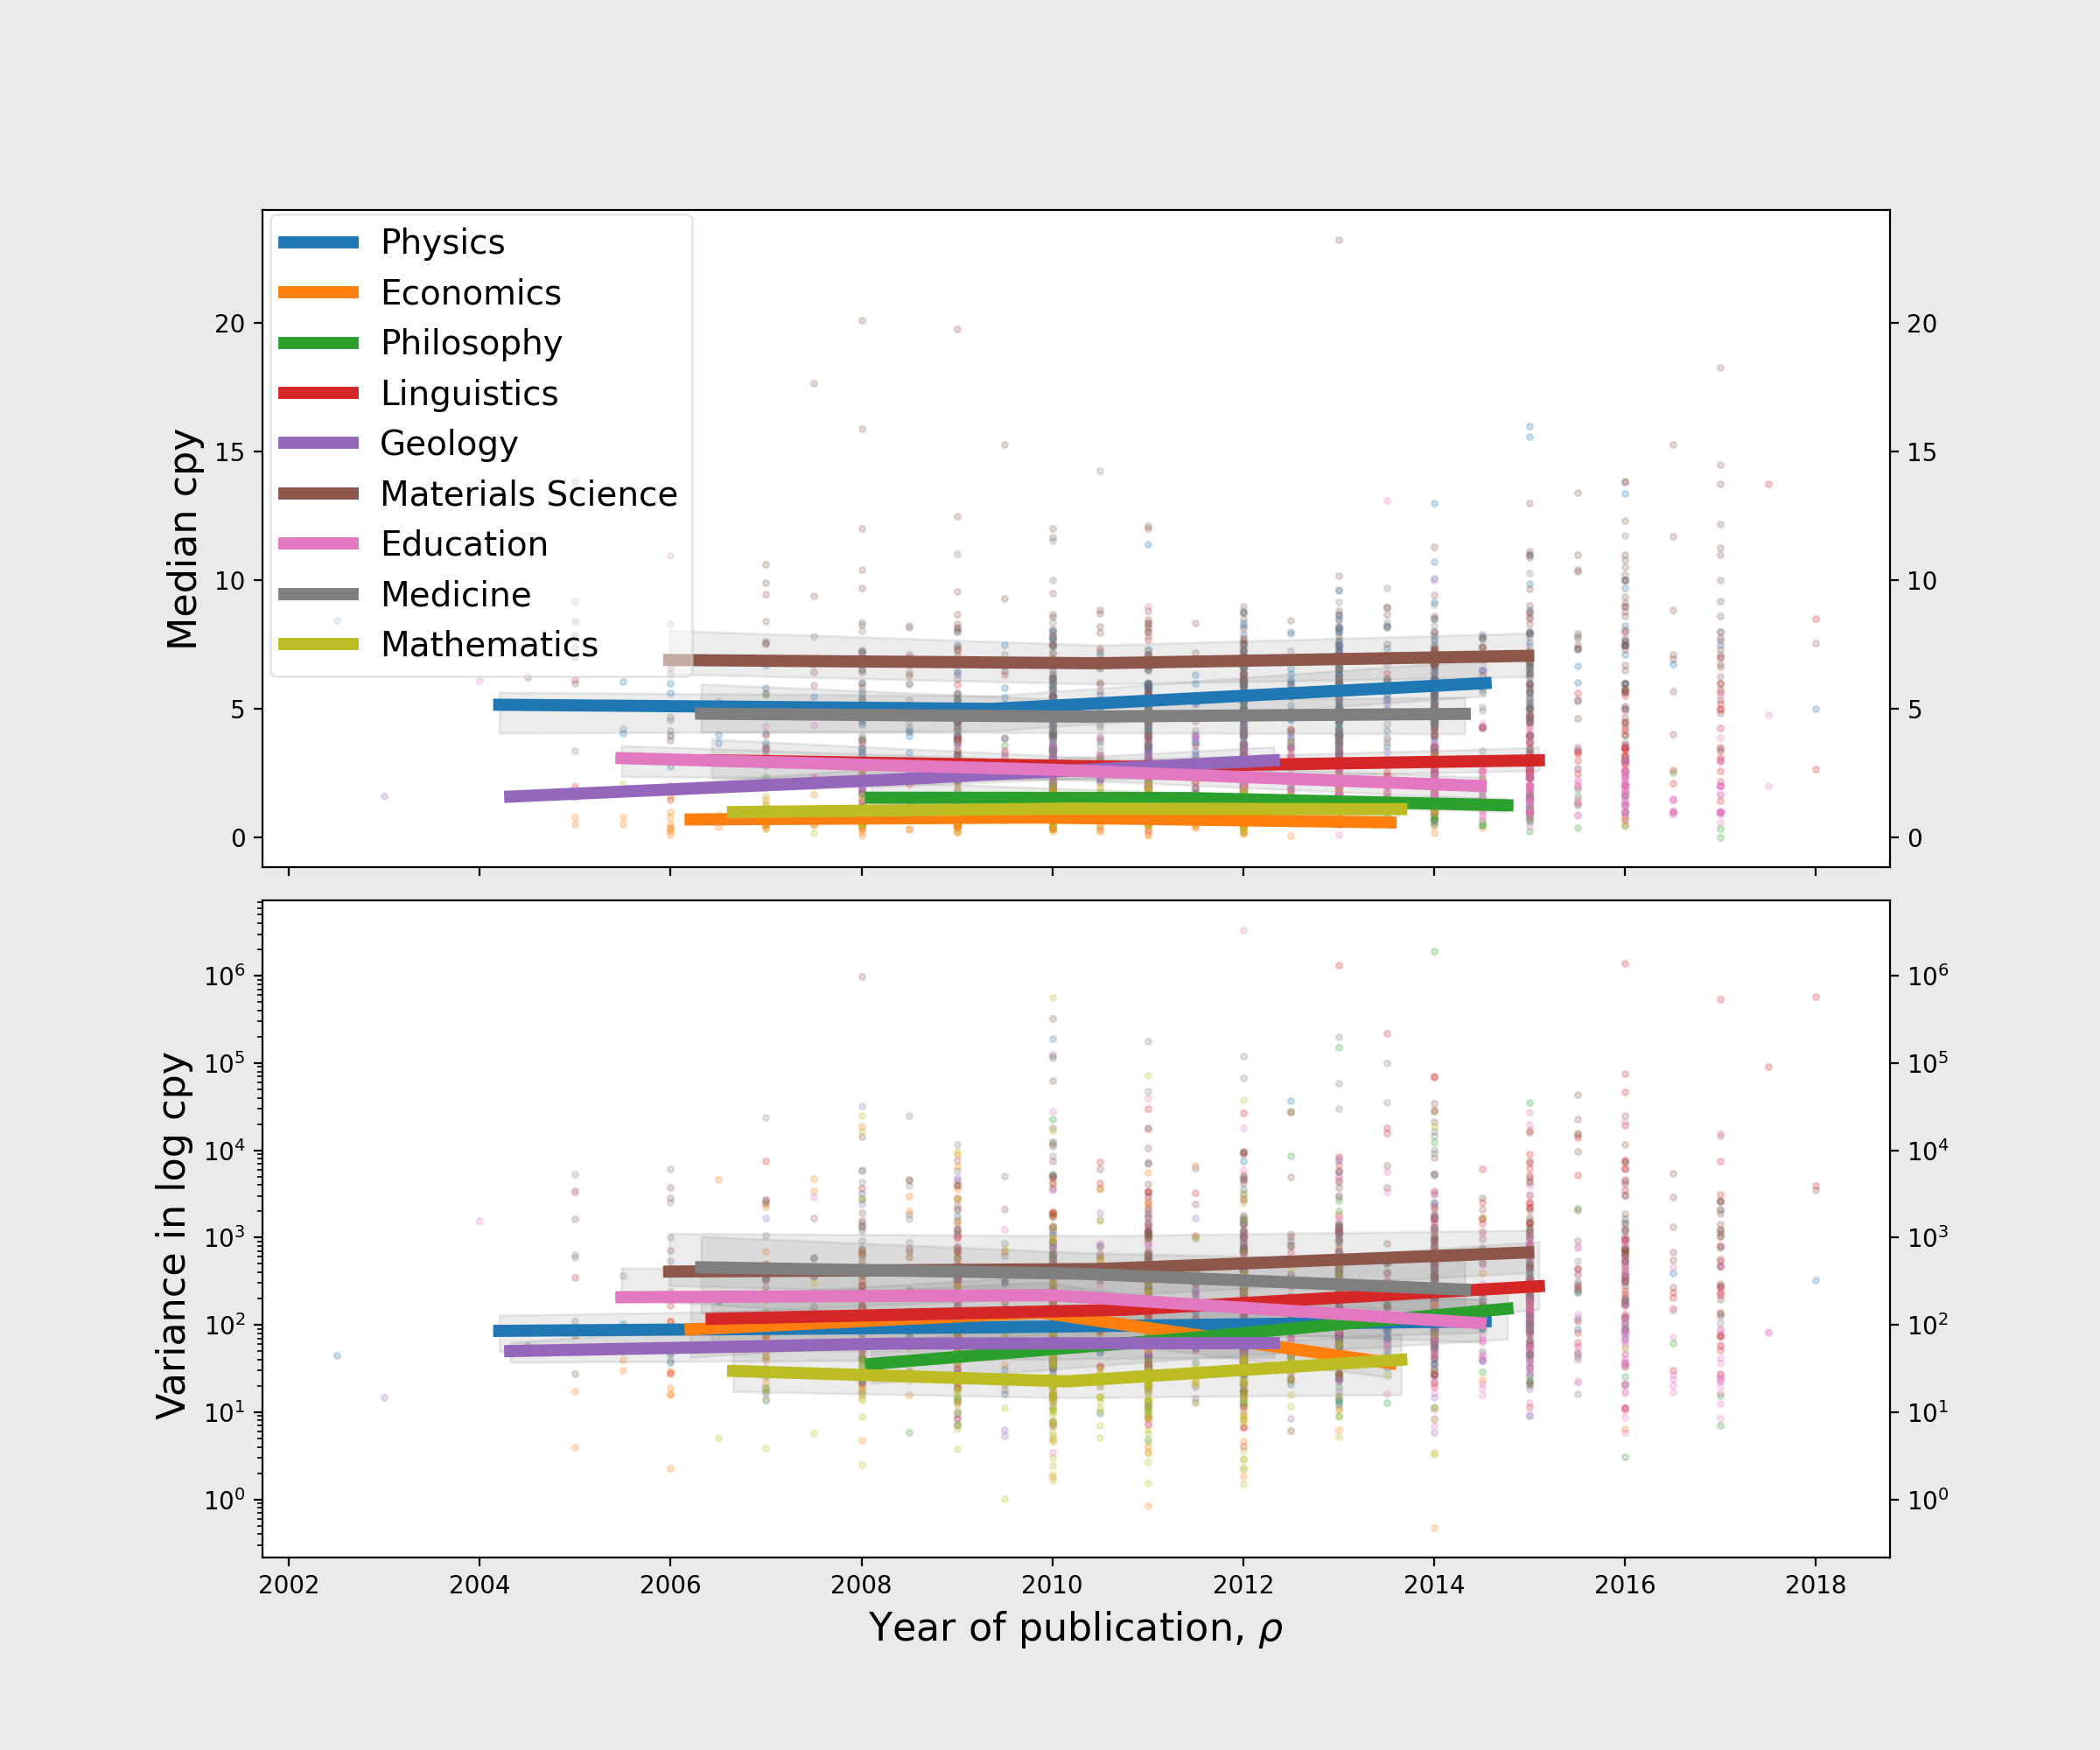

In [75]:
import warnings
import matplotlib.gridspec as gridspec


df_plot = df_ent_new

# df_plot = pd.concat(
#     [get_df_var(df, field, n_bin=20)
#     for field in df["fields_of_study_0"].unique()],
# )


rows = ["median", "variance"]
n_rows = 2

fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )
# ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "year_med"
# x_variable = "density_bin"
# x_variable = "density_med_bin"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    #######################################
    # Fields
    #######################################      

    fields = df_ent_new.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_field = df_plot[df_plot["field"] == field]

        x_observations_field = df_field[x_variable]
        y_observations_field = df_field[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            4,
        )

        xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 68 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 32 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            mult * xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            mult * x_observations_field,
            y_observations_field,
            alpha = 0.2,
            s=6,
            # label=field,
        )    

        ax.plot(
            mult * xs,
            median,
            linewidth = 5,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)                
        # ax.set_xlim(22,47)        
        # ax.set_ylim(0,11)
        # ax.set_ylabel( 'Median references', fontsize=16 )
        ax.set_ylabel( 'Median cpy', fontsize=16 )        

        # Customize ticks
        # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
        # ax.tick_params( which='minor', direction='in', size=0, width=2, )


    if row == "variance":
        ax.set_yscale( 'log' )
        # ax.set_ylim(10,1e4)
        # ax.set_xlim(22,47)
        # ax.set_ylim(0,1.,)
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)        

        # ax.set_ylabel( 'Variance in # references ', fontsize=16 )
        ax.set_ylabel( 'Variance in log cpy ', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.62, axbox.y0 + 0.2),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_xlabel( r'Year of publication, $\rho$', fontsize=16 )

# plt.tight_layout()

plt.show()
